<h1 align=center><font size = 5>Clustering and Comparing the Neighborhoods of Fairfax County in Virginia</font></h1>


# 1.1. Introduction

Fairfax County is a suburb of Washington D.C. in northern Virginia. It is the most populous county in the state and has some of the most expensive housing markets in the DC-Maryland-Virginia (DMV) metropolitan region. Despite the global impact of the coronavirus pandemic, the real estate market in Fairfax County remains strong and competitive.  A relatively strong economy mainly drives this competitiveness in the DMV area. Other factors that influence the real estate market are lack of inventory, low mortgage rates, and trim down payment options. However, the real estate market boom may not be uniform across different neighborhoods in the county; therefore, there is an opportunity to use data analysis to compare various localities and generate insights for potential investments. 

## 1.2. Business Problem

Insights and data often assist successful investments. This project will utilize a machine learning technique to derive these insights and provide a mechanism for potential homebuyers or investors to make an informed decision. In particular, the business problem that we are trying to answer is: What neighborhood offers the best opportunity for purchasing a home or an investment property in Fairfax County? 
To solve this problem, we will cluster various neighborhoods of Fairfax County, using local venues and amenities like coffee shops, parks, etc., and a smoothed and seasonally adjusted value of typical homes across the region. We will then compare these clusters' results with the forecasted increase in home prices in each neighborhood to derive valuable insight for purchasing a home or an investment property. 


# 2. Data Acquisition
## 2.1. Data 
In this project, we need three types of data to answer our business question. The data that we need include names of neighborhoods, venues and amenities, average home prices, and the forecasted increase in housing prices. 
The neighborhood dataset includes the names of various localities in Fairfax County. Using each neighborhood's name, we can obtain their complete address, latitude, and longitude information from the GeoCoder library in Python.  We can use the Foursquare API to get relevant information about different venues and amenities in each neighborhood; and housing data from Zillow. To clean, analyze, and process the data, we will utilize pandas dataframe. 

We will load the neighborhood list in Fairfax County from a CSV file into a pandas dataframe. The CSV file was downloaded from https://www.fairfaxcounty.gov/demographics/interactive-map-communities-places-and-towns. Fairfax County offers an interactive map for selecting communities and towns within its borders. 

The Foursquare API offers access to the largest sources of locational data, such as venues and amenities. It is a location technology platform. Zillow is the leading real estate and rental marketplace that serves the entire lifecycle of owning a home, such as buying, selling, renting, financing, and remodeling. Zillow makes housing data available for download via the following link: https://www.zillow.com/research/data/. We will utilize the Zillow Home Value Index (ZHVI) and Zillow Home Value Forecast (ZHVF) for this project, where ZHVI is a smoothed, seasonally adjusted measure of typical home values and market conditions for a given region. Zillow publishes ZHVI for different price tiers, but for this project, we are using the mid-tier dataset, which reflects home values in the 35th to 65th percentile range.  ZHVF is the one-year forecast of ZHVI.  Both ZHVI and ZHVF files are downloaded as CSV files and will be uploaded into pandas dataframes for post-processing.


### Import Libraries

In [181]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import geojson

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="Fairfax_explorer")

import requests # library to handle requests

from pandas import json_normalize

import seaborn as sns; sns.set_theme(color_codes=True)
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from scipy import stats

import folium # map rendering library

import urllib.request
from bs4 import BeautifulSoup # to parse HTMLand XML
from IPython.display import display_html

import re

print('Libraries imported.')

Libraries imported.


## 2.2 Neighborhoods Data for Fairfax County

In [182]:
fairfax_neighborhoods_df = pd.read_csv('Data/FairfaxNeighborhoods.csv')
fairfax_neighborhoods_df.head()

NAMELSAD10  YEAR  POPULATION  POP_5YEAR  LAND_AREA  TOTAL_HU   SFD  \
0      Woodburn CDP  2020        8937       9002   1790.464      3161  1486   
1  Burke Centre CDP  2020       17339      17370   2024.901      6172  2299   
2     Fair Oaks CDP  2020       34151      36135   3232.245     15101  1136   
3   Crosspointe CDP  2020        6034       6042   1420.916      1820  1820   
4     Wakefield CDP  2020       11726      11769   2434.220      3926  3789   

    SFA  MF_LOW  MF_MID  MF_HIGH  HOUSEHOLDS  HU_30UP  HU_LT30  VALUE_LOW  \
0   587    1088       0        0        3116     3028      131        936   
1  2953     920       0        0        6153     5981      189       3250   
2  5007    8567     391        0       14763     4989    10111       4578   
3     0       0       0        0        1810      807     1012         51   
4   137       0       0        0        3911     3777      149        137   

   VALUE_MID  VALUE_HIGH  TOTAL_GFA  OFFICE_GFA  RETAIL_GFA  INDUST_GFA  
0       1369          91    3191725     3060943      130782           0  
1       2321          27    1611310      170736     1091745      348829  
2       3764         247   13557126     6842130     6368746      346250  
3       1715          51     347650           0      347650           0  
4       3700          83          0           0           0           0

##### Removing the additional information 'CDP' from the Name column of the fairfax_neighborhoods dataframe and renaming the first column Neighborhoods

In [183]:
fairfax_neighborhoods_df["NAMELSAD10"] = fairfax_neighborhoods_df["NAMELSAD10"].str.replace(" CDP", "")
fairfax_neighborhoods_df.rename(columns = {'NAMELSAD10':'Neighborhoods'}, inplace = True)

fairfax_neighborhoods_df.head(20)

Neighborhoods  YEAR  POPULATION  POP_5YEAR  LAND_AREA  TOTAL_HU   SFD  \
0          Woodburn  2020        8937       9002   1790.464      3161  1486   
1      Burke Centre  2020       17339      17370   2024.901      6172  2299   
2         Fair Oaks  2020       34151      36135   3232.245     15101  1136   
3       Crosspointe  2020        6034       6042   1420.916      1820  1820   
4         Wakefield  2020       11726      11769   2434.220      3926  3789   
5        Mason Neck  2020        2367       2403  12813.096       817   815   
6            McNair  2020       22015      27369   1320.213      9508    86   
7         South Run  2020        6843       6836   1664.018      2123  2000   
8        Greenbriar  2020        8190       8193   1008.979      3134  1940   
9        Fair Lakes  2020        8956       9161   1545.597      3430   642   
10  Fairfax Station  2020       12412      12435   5870.106      4162  3510   
11           Floris  2020        8941       9673   1779.774      2717  2242   
12       Kings Park  2020        4667       4670    851.282      1467  1141   
13  Kings Park West  2020       14033      14085   1943.416      4443  3019   
14     George Mason  2020       11211      11973   1619.333      1585  1471   
15      Ravensworth  2020        2709       2712    628.701       854   854   
16      Long Branch  2020        8055       8085   1585.527      2739  2436   
17    Franklin Farm  2020       20320      20358   3058.621      6221  5530   
18       Kingstowne  2020       16862      17538   1858.901      7106  1010   
19         Hayfield  2020        3939       3945    893.119      1467  1036   

     SFA  MF_LOW  MF_MID  MF_HIGH  HOUSEHOLDS  HU_30UP  HU_LT30  VALUE_LOW  \
0    587    1088       0        0        3116     3028      131        936   
1   2953     920       0        0        6153     5981      189       3250   
2   5007    8567     391        0       14763     4989    10111       4578   
3      0       0       0        0        1810      807     1012         51   
4    137       0       0        0        3911     3777      149        137   
5      2       0       0        0         797      637      172        224   
6   2815    6200     407        0        9256      285     9221       2564   
7    123       0       0        0        2119     1368      754          2   
8    197     997       0        0        3125     2965      168        606   
9   1452     978     358        0        3349      738     2689       1444   
10   652       0       0        0        4112     3604      549        722   
11   315     160       0        0        2709     1187     1528        162   
12   326       0       0        0        1466     1465        2        331   
13  1424       0       0        0        4437     4254      189       1218   
14   102      12       0        0        1562     1164      267        325   
15     0       0       0        0         853      841       13        161   
16    33     270       0        0        2712     2457      279         53   
17   691       0       0        0        6205     5311      908        994   
18  3806    2290       0        0        6997     2705     4398       2551   
19   431       0       0        0        1465     1378       88        396   

    VALUE_MID  VALUE_HIGH  TOTAL_GFA  OFFICE_GFA  RETAIL_GFA  INDUST_GFA  
0        1369          91    3191725     3060943      130782           0  
1        2321          27    1611310      170736     1091745      348829  
2        3764         247   13557126     6842130     6368746      346250  
3        1715          51     347650           0      347650           0  
4        3700          83          0           0           0           0  
5         438         111       1284           0           0        1284  
6         833           0    9736348     6761503     2940195       34650  
7        2056          64       2376           0           0        2376  
8        1737           0     79

##### Print the size of the data

In [184]:
fairfax_neighborhoods_df.shape

(72, 21)

##### Clean the fairfax_neighborhoods dataframe by removing neighborhoods (rows) that have no names e.g., Non Area 4, and create a new dataframe fairfax_data

In [185]:
temp_df = fairfax_neighborhoods_df;
temp_df['Neighborhoods'] = temp_df["Neighborhoods"].str.replace("Non Area ", "1Null")
fairfax_data = temp_df[~temp_df.Neighborhoods.str.match('^[1]')].reset_index(drop = True)

fairfax_data.head(20)

Neighborhoods  YEAR  POPULATION  POP_5YEAR  LAND_AREA  TOTAL_HU   SFD  \
0          Woodburn  2020        8937       9002   1790.464      3161  1486   
1      Burke Centre  2020       17339      17370   2024.901      6172  2299   
2         Fair Oaks  2020       34151      36135   3232.245     15101  1136   
3       Crosspointe  2020        6034       6042   1420.916      1820  1820   
4         Wakefield  2020       11726      11769   2434.220      3926  3789   
5        Mason Neck  2020        2367       2403  12813.096       817   815   
6            McNair  2020       22015      27369   1320.213      9508    86   
7         South Run  2020        6843       6836   1664.018      2123  2000   
8        Greenbriar  2020        8190       8193   1008.979      3134  1940   
9        Fair Lakes  2020        8956       9161   1545.597      3430   642   
10  Fairfax Station  2020       12412      12435   5870.106      4162  3510   
11           Floris  2020        8941       9673   1779.774      2717  2242   
12       Kings Park  2020        4667       4670    851.282      1467  1141   
13  Kings Park West  2020       14033      14085   1943.416      4443  3019   
14     George Mason  2020       11211      11973   1619.333      1585  1471   
15      Ravensworth  2020        2709       2712    628.701       854   854   
16      Long Branch  2020        8055       8085   1585.527      2739  2436   
17    Franklin Farm  2020       20320      20358   3058.621      6221  5530   
18       Kingstowne  2020       16862      17538   1858.901      7106  1010   
19         Hayfield  2020        3939       3945    893.119      1467  1036   

     SFA  MF_LOW  MF_MID  MF_HIGH  HOUSEHOLDS  HU_30UP  HU_LT30  VALUE_LOW  \
0    587    1088       0        0        3116     3028      131        936   
1   2953     920       0        0        6153     5981      189       3250   
2   5007    8567     391        0       14763     4989    10111       4578   
3      0       0       0        0        1810      807     1012         51   
4    137       0       0        0        3911     3777      149        137   
5      2       0       0        0         797      637      172        224   
6   2815    6200     407        0        9256      285     9221       2564   
7    123       0       0        0        2119     1368      754          2   
8    197     997       0        0        3125     2965      168        606   
9   1452     978     358        0        3349      738     2689       1444   
10   652       0       0        0        4112     3604      549        722   
11   315     160       0        0        2709     1187     1528        162   
12   326       0       0        0        1466     1465        2        331   
13  1424       0       0        0        4437     4254      189       1218   
14   102      12       0        0        1562     1164      267        325   
15     0       0       0        0         853      841       13        161   
16    33     270       0        0        2712     2457      279         53   
17   691       0       0        0        6205     5311      908        994   
18  3806    2290       0        0        6997     2705     4398       2551   
19   431       0       0        0        1465     1378       88        396   

    VALUE_MID  VALUE_HIGH  TOTAL_GFA  OFFICE_GFA  RETAIL_GFA  INDUST_GFA  
0        1369          91    3191725     3060943      130782           0  
1        2321          27    1611310      170736     1091745      348829  
2        3764         247   13557126     6842130     6368746      346250  
3        1715          51     347650           0      347650           0  
4        3700          83          0           0           0           0  
5         438         111       1284           0           0        1284  
6         833           0    9736348     6761503     2940195       34650  
7        2056          64       2376           0           0        2376  
8        1737           0     79

##### Get the corresponding latitude and longitude values for each neighborhood in Fairfax County

In [186]:
latitudes = []
longitudes = []
location_address = []

for line in fairfax_data['Neighborhoods']: #fairfax_neighborhoods_df['Neighborhoods']:
    address = line.strip()
    location = geolocator.geocode(address + ' Fairfax County Virginia')
      
    if location and len(location):
        
        latitude  = location.latitude
        longitude = location.longitude
        latitudes.append(latitude)
        longitudes.append(longitude)
        location_address.append(location.address) 
    else:
        sys.stderr.write("not found: %s\n" % address)

#### Tranform the data into a pandas dataframe by creating an empty dataframe and populating it with latitude and longitude data.

In [187]:
fairfax_geo_location = pd.DataFrame() #creat an empty dataframe

#Syntex: DataFrameName.insert(loc, column, value, allow_duplicates = False)
fairfax_geo_location.insert(0, 'Neighborhoods', fairfax_data['Neighborhoods'], allow_duplicates = True)
fairfax_geo_location.insert(1, 'Full_Address', location_address, allow_duplicates = True)
fairfax_geo_location.insert(2,'Latitude', latitudes, allow_duplicates = True)
fairfax_geo_location.insert(3, 'Longitude', longitudes, allow_duplicates = True)


fairfax_geo_location.head()

Neighborhoods                                       Full_Address   Latitude  \
0      Woodburn  Woodburn School Site Park, Holmes Run Acres, A...  38.852209   
1  Burke Centre  Burke Centre, Fairfax County, Virginia, 22015-...  38.790992   
2     Fair Oaks  Fair Oaks, Fairfax County, Virginia, 22035, Un...  38.863427   
3   Crosspointe  Crosspointe, Laurel Hill, Fairfax County, Virg...  38.724002   
4     Wakefield  Wakefield Forest, Fairfax County, Virginia, 22...  38.835395   

   Longitude  
0 -77.211870  
1 -77.300519  
2 -77.359230  
3 -77.265078  
4 -77.239581

#### We need to obtain zip codes for each neighborhood in Fairfax County, using the latitude and longitude values we just computed. We will need the zip code information for obtaining housing prices.

##### Define a function to get zip codes

In [188]:
def get_zipcodes(geolocator, lat_data, lon_data):
    zipcodes = []
    for lat, long in zip(lat_data, lon_data):
        location = geolocator.reverse((lat, long))        
        try:
            zipcodes.append(location.raw['address']['postcode'])
        except:
            zipcodes.append(np.nan)
    return zipcodes

##### Use the get_zipcodes function to obtain zip codes and add them to the fairfax geo location dataframe

In [189]:
geolocator = Nominatim(user_agent="Fairfax_Zips")
fx_zip = get_zipcodes(geolocator, latitudes, longitudes)
fairfax_geo_location['Zipcode'] = fx_zip
fairfax_geo_location.head()

Neighborhoods                                       Full_Address   Latitude  \
0      Woodburn  Woodburn School Site Park, Holmes Run Acres, A...  38.852209   
1  Burke Centre  Burke Centre, Fairfax County, Virginia, 22015-...  38.790992   
2     Fair Oaks  Fair Oaks, Fairfax County, Virginia, 22035, Un...  38.863427   
3   Crosspointe  Crosspointe, Laurel Hill, Fairfax County, Virg...  38.724002   
4     Wakefield  Wakefield Forest, Fairfax County, Virginia, 22...  38.835395   

   Longitude Zipcode  
0 -77.211870     NaN  
1 -77.300519   22015  
2 -77.359230   22035  
3 -77.265078   22079  
4 -77.239581   22003

#### As can be seen from the fairfax_goe_location data, not all neighborhoods returned a value representing a zip code. We need to remove neighborhoods that do not have a zip code

##### Remove neighborhoods that do not have a zip code and create a new dataframe

In [190]:
new_fx_geo_location = fairfax_geo_location.dropna(axis = 0, how = 'any', inplace = False)
new_fx_geo_location = new_fx_geo_location.reset_index(drop = True)
new_fx_geo_location.head()

Neighborhoods                                       Full_Address   Latitude  \
0  Burke Centre  Burke Centre, Fairfax County, Virginia, 22015-...  38.790992   
1     Fair Oaks  Fair Oaks, Fairfax County, Virginia, 22035, Un...  38.863427   
2   Crosspointe  Crosspointe, Laurel Hill, Fairfax County, Virg...  38.724002   
3     Wakefield  Wakefield Forest, Fairfax County, Virginia, 22...  38.835395   
4        McNair  McNair, Fairfax County, Virginia, 20171-3025, ...  38.952295   

   Longitude Zipcode  
0 -77.300519   22015  
1 -77.359230   22035  
2 -77.265078   22079  
3 -77.239581   22003  
4 -77.414295   20171

#### Notice that we have fewer neighborhoods in our dataframe

In [191]:
new_fx_geo_location.shape

(58, 5)

##### Extract the name of Fairfax County and create a new dataframe county. This information will be used for rendering these neighborhoods

In [192]:
county = new_fx_geo_location['Full_Address'].str.extract(r'(Fairfax County*)', expand = True)
county.columns = ['Locality']
county.head()

Locality
0  Fairfax County
1  Fairfax County
2  Fairfax County
3  Fairfax County
4  Fairfax County

#### Create a map of Fairfax County with neighborhoods superimposed on county's border. The neighborhoods are plotted using latitude and longitude values, and the border is plotted using data from the geojson file                           

##### Open a geojson file that contains the geographic boundries of Fairfax County and load it

In [193]:
with open('Data/County_Border.geojson') as fx_border:
    fairfax_geo_json_data = geojson.load(fx_border)

##### Create a map of Fairfax County and its neighborhoods in our dataset

In [194]:
lat_county = 38.9085
lon_county = -77.2405

# creaet the overall map of Fairfax County
map_fairfax = folium.Map(location=[lat_county, lon_county], zoom_start = 11)

# Add the borders onto the the map_fairfax
folium.GeoJson(
    fairfax_geo_json_data,
    style_function=lambda feature: {
        "fillColor": "#a89732",
        "color": "black",
        "weight": 2,
        "dashArray": "5, 5",
    },
).add_to(map_fairfax)

# add neighborhood markers to map
for lat, lng, neighborhood, county_ in zip(new_fx_geo_location['Latitude'], new_fx_geo_location['Longitude'], new_fx_geo_location['Neighborhoods'], county['Locality']):
   
    label = '{}, {}'.format(neighborhood, county_)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 7,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html=False).add_to(map_fairfax)  
    
map_fairfax

## 2.3 Housing Price Data

#### Now that we have neighborhood data, we need to import housing price data and forecasted percentage change in the housing prices in each neighborhood

##### Import a forecasted percentage change in the price of houses for different neighborhoods

In [195]:
housing_price_forecast = pd.read_csv('Data/zhvf_uc_sfrcondo_tier_0.33_0.67_raw_mon.csv')
housing_price_forecast.head()

Region     RegionName StateName CountyName CityName ForecastedDate  \
0  Country  United States       NaN        NaN      NaN     2022-02-28   
1      Msa   Aberdeen, SD        SD        NaN      NaN     2022-02-28   
2      Msa   Aberdeen, WA        WA        NaN      NaN     2022-02-28   
3      Msa    Abilene, TX        TX        NaN      NaN     2022-02-28   
4      Msa        Ada, OK        OK        NaN      NaN     2022-02-28   

   ForecastYoYPctChange  
0                  10.4  
1                   6.8  
2                  15.6  
3                   3.7  
4                   7.5

##### Let's see the size of the housing price forecasted data

In [196]:
housing_price_forecast.shape

(30953, 7)

#### As can be seen from the shape of the housing data, there are more than thirty thousands entries, covering various states and counties across the U.S. We only need data for Fairfax County, VA. 

##### Remove all entries without a county name

In [197]:
housing_price_forecast = housing_price_forecast.dropna()
housing_price_forecast = housing_price_forecast.reset_index(drop=True)
housing_price_forecast.head()

Region RegionName StateName           CountyName    CityName ForecastedDate  \
0    Zip      00501        NY       Suffolk County  Holtsville     2022-02-28   
1    Zip      00602        AL           Lee County      Auburn     2022-02-28   
2    Zip      00606        MO        Newton County      Neosho     2022-02-28   
3    Zip      00693        PA  Westmoreland County  Greensburg     2022-02-28   
4    Zip      00705        UT          Kane County    Aibonito     2022-02-28   

   ForecastYoYPctChange  
0                   5.9  
1                   4.5  
2                   6.8  
3                   8.2  
4                   3.2

##### Check the size of the dataframe again

In [198]:
housing_price_forecast.shape

(30043, 7)

##### Extract rows of data that contains the word Fairfax County and create a new dataframe called fairfax housing price forecast or fairfax_hp_f for short. 

In [199]:
fairfax_hp_f = housing_price_forecast[housing_price_forecast['CountyName'].str.contains('Fairfax County')].reset_index(drop = True)
fairfax_hp_f.shape

(41, 7)

In [200]:
fairfax_hp_f.head()

Region RegionName StateName      CountyName     CityName ForecastedDate  \
0    Zip      20120        VA  Fairfax County  Centreville     2022-02-28   
1    Zip      20121        VA  Fairfax County  Centreville     2022-02-28   
2    Zip      20124        VA  Fairfax County      Clifton     2022-02-28   
3    Zip      20170        VA  Fairfax County      Herndon     2022-02-28   
4    Zip      20171        VA  Fairfax County      Herndon     2022-02-28   

   ForecastYoYPctChange  
0                   5.9  
1                   5.8  
2                   5.6  
3                   5.8  
4                   5.7

##### Rename the RegionName column to Zipcode so that we can join the dataframes based on zip codes

In [201]:
fairfax_hp_f.rename(columns = {'RegionName':'Zipcode'}, inplace = True)
fairfax_hp_f.head() 

Region Zipcode StateName      CountyName     CityName ForecastedDate  \
0    Zip   20120        VA  Fairfax County  Centreville     2022-02-28   
1    Zip   20121        VA  Fairfax County  Centreville     2022-02-28   
2    Zip   20124        VA  Fairfax County      Clifton     2022-02-28   
3    Zip   20170        VA  Fairfax County      Herndon     2022-02-28   
4    Zip   20171        VA  Fairfax County      Herndon     2022-02-28   

   ForecastYoYPctChange  
0                   5.9  
1                   5.8  
2                   5.6  
3                   5.8  
4                   5.7

##### Let's join our Fairfax geo location data and the forecast in percentage change in housing price data, using the zip code columns

In [202]:
forecasted_price_fairfax_merged = new_fx_geo_location.join(fairfax_hp_f.set_index('Zipcode'), on = 'Zipcode')
forecasted_price_fairfax_merged.shape

(58, 11)

##### Let's see the data after the join operation was performed

In [203]:
forecasted_price_fairfax_merged.head()

Neighborhoods                                       Full_Address   Latitude  \
0  Burke Centre  Burke Centre, Fairfax County, Virginia, 22015-...  38.790992   
1     Fair Oaks  Fair Oaks, Fairfax County, Virginia, 22035, Un...  38.863427   
2   Crosspointe  Crosspointe, Laurel Hill, Fairfax County, Virg...  38.724002   
3     Wakefield  Wakefield Forest, Fairfax County, Virginia, 22...  38.835395   
4        McNair  McNair, Fairfax County, Virginia, 20171-3025, ...  38.952295   

   Longitude Zipcode Region StateName      CountyName   CityName  \
0 -77.300519   22015    Zip        VA  Fairfax County      Burke   
1 -77.359230   22035    NaN       NaN             NaN        NaN   
2 -77.265078   22079    Zip        VA  Fairfax County     Lorton   
3 -77.239581   22003    Zip        VA  Fairfax County  Annandale   
4 -77.414295   20171    Zip        VA  Fairfax County    Herndon   

  ForecastedDate  ForecastYoYPctChange  
0     2022-02-28                   5.8  
1            NaN                   NaN  
2     2022-02-28                   5.8  
3     2022-02-28                   5.9  
4     2022-02-28                   5.7

#### Notice that our Fairfax geo location data contains more neighborhoods, but we have fewer corresponding zip codes in the Fairfax forecasted housing price dataset

##### Clean the data and drop neighborhoods that do not have a zip code, and create a new dataframe

In [204]:
updated_forecasted_price_fairfax_merged = forecasted_price_fairfax_merged.dropna()
updated_forecasted_price_fairfax_merged = updated_forecasted_price_fairfax_merged.reset_index(drop = True)
updated_forecasted_price_fairfax_merged.head()

Neighborhoods                                       Full_Address   Latitude  \
0  Burke Centre  Burke Centre, Fairfax County, Virginia, 22015-...  38.790992   
1   Crosspointe  Crosspointe, Laurel Hill, Fairfax County, Virg...  38.724002   
2     Wakefield  Wakefield Forest, Fairfax County, Virginia, 22...  38.835395   
3        McNair  McNair, Fairfax County, Virginia, 20171-3025, ...  38.952295   
4     South Run  South Run, Fairfax County, Virginia, 22039, Un...  38.747437   

   Longitude Zipcode Region StateName      CountyName   CityName  \
0 -77.300519   22015    Zip        VA  Fairfax County      Burke   
1 -77.265078   22079    Zip        VA  Fairfax County     Lorton   
2 -77.239581   22003    Zip        VA  Fairfax County  Annandale   
3 -77.414295   20171    Zip        VA  Fairfax County    Herndon   
4 -77.281867   22039    Zip        VA  Fairfax County     Lorton   

  ForecastedDate  ForecastYoYPctChange  
0     2022-02-28                   5.8  
1     2022-02-28                   5.8  
2     2022-02-28                   5.9  
3     2022-02-28                   5.7  
4     2022-02-28                   5.8

##### Check the size of our new combined dataframe

In [205]:
updated_forecasted_price_fairfax_merged.shape

(52, 11)

#### Load historical housing price information

In [206]:
housing_prices = pd.read_csv('Data/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')
housing_prices.head()

RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     61639         0       10025        Zip        NY    NY  New York   
1     84654         1       60657        Zip        IL    IL   Chicago   
2     61637         2       10023        Zip        NY    NY  New York   
3     91982         3       77494        Zip        TX    TX      Katy   
4     84616         4       60614        Zip        IL    IL   Chicago   

                              Metro       CountyName  1996-01-31  1996-02-29  \
0       New York-Newark-Jersey City  New York County    232527.0    231079.0   
1          Chicago-Naperville-Elgin      Cook County    208780.0    208625.0   
2       New York-Newark-Jersey City  New York County    184917.0    184955.0   
3  Houston-The Woodlands-Sugar Land    Harris County    199929.0    200176.0   
4          Chicago-Naperville-Elgin      Cook County    281068.0    280811.0   

   1996-03-31  1996-04-30  1996-05-31  1996-06-30  1996-07-31  1996-08-31  \
0    231156.0    231131.0    231660.0    232303.0    232189.0    233004.0   
1    208220.0    208086.0    207527.0    207709.0    207498.0    208100.0   
2    185058.0    185717.0    186675.0    187460.0    187721.0    187799.0   
3    199980.0    198794.0    197659.0    196995.0    197755.0    197444.0   
4    280293.0    280152.0    279477.0    279565.0    279073.0    279632.0   

   1996-09-30  1996-10-31  1996-11-30  1996-12-31  1997-01-31  1997-02-28  \
0    233358.0    234978.0    236222.0    237784.0    239242.0    242128.0   
1    208982.0    210481.0    212131.0    213375.0    214829.0    216221.0   
2    188094.0    188653.0    189402.0    190174.0    191207.0    192674.0   
3    196792.0    196004.0    196904.0    198584.0    201137.0    202377.0   
4    280708.0    282640.0    284909.0    286851.0    289487.0    291594.0   

   1997-03-31  1997-04-30  1997-05-31  1997-06-30  1997-07-31  1997-08-31  \
0    243761.0    244686.0    245518.0    246394.0    249020.0    249559.0   
1    218041.0    218793.0    220497.0    221091.0    222367.0    221917.0   
2    194474.0    195781.0    196895.0    198301.0    200415.0    202614.0   
3    203650.0    205850.0    208300.0    210007.0    209676.0    211814.0   
4    293823.0    294435.0    296257.0    296973.0    298096.0    297277.0   

   1997-09-30  1997-10-31  1997-11-30  1997-12-31  1998-01-31  1998-02-28  \
0    251200.0    250857.0    252853.0    255463.0    258902.0    262192.0   
1    220814.0    218823.0    217112.0    216830.0    216851.0    217205.0   
2    204777.0    206792.0    209007.0    211538.0    213901.0    215575.0   
3    214317.0    216515.0    215586.0    213881.0    211157.0    209551.0   
4    295389.0    292473.0    289808.0    288722.0    287331.0    286985.0   

   1998-03-31  1998-04-30  1998-05-31  1998-06-30  1998-07-31  1998-08-31  \
0    266377.0    271217.0    275049.0    279088.0    281662.0    286647.0   
1    217693.0    219126.0    220469.0    222036.0    223738.0    226938.0   
2    216772.0    217833.0    218950.0    220621.0    222671.0    225195.0   
3    207850.0    206914.0    205878.0    205470.0    205363.0    204089.0   
4    287403.0    289190.0    290959.0    292906.0    295963.0    300356.0   

   1998-09-30  1998-10-31  1998-11-30  1998-12-31  1999-01-31  1999-02-28  \
0    291438.0    297970.0    301747.0    304445.0    307239.0    310102.0   
1    231318.0    236296.0    240885.0    244528.0    247339.0    249824.0   
2    227007.0    228894.0    230320.0    231816.0    232936.0    234502.0   
3    203577.0    204043.0    205662.0    206517.0    207060.0    207771.0   
4    306200.0    312439.0    317964.0    322204.0    325500.0    328567.0   

   1999-03-31  1999-04-30  1999-05-31  1999-06-30  1999-07-31  1999-08-31  \
0    313135.0    315312.0    319584.0    324729.0    332882.0    340698.0   
1    252169.0    254654.0    257107.0    260489.0    264131.0    267367.0   
2    236477.0    238973.0    241183.0    242536.0    244085.0    246

#### As can be seen from the housing_prices dataframe, there are historial housing prices for various counties and localities across the U.S., we are only interested in data for Fairfax County, VA.

##### Rename the RegionName column to Zipcode

In [207]:
housing_prices.rename(columns = {'RegionName':'Zipcode'}, inplace = True)
housing_prices.head()

RegionID  SizeRank  Zipcode RegionType StateName State      City  \
0     61639         0    10025        Zip        NY    NY  New York   
1     84654         1    60657        Zip        IL    IL   Chicago   
2     61637         2    10023        Zip        NY    NY  New York   
3     91982         3    77494        Zip        TX    TX      Katy   
4     84616         4    60614        Zip        IL    IL   Chicago   

                              Metro       CountyName  1996-01-31  1996-02-29  \
0       New York-Newark-Jersey City  New York County    232527.0    231079.0   
1          Chicago-Naperville-Elgin      Cook County    208780.0    208625.0   
2       New York-Newark-Jersey City  New York County    184917.0    184955.0   
3  Houston-The Woodlands-Sugar Land    Harris County    199929.0    200176.0   
4          Chicago-Naperville-Elgin      Cook County    281068.0    280811.0   

   1996-03-31  1996-04-30  1996-05-31  1996-06-30  1996-07-31  1996-08-31  \
0    231156.0    231131.0    231660.0    232303.0    232189.0    233004.0   
1    208220.0    208086.0    207527.0    207709.0    207498.0    208100.0   
2    185058.0    185717.0    186675.0    187460.0    187721.0    187799.0   
3    199980.0    198794.0    197659.0    196995.0    197755.0    197444.0   
4    280293.0    280152.0    279477.0    279565.0    279073.0    279632.0   

   1996-09-30  1996-10-31  1996-11-30  1996-12-31  1997-01-31  1997-02-28  \
0    233358.0    234978.0    236222.0    237784.0    239242.0    242128.0   
1    208982.0    210481.0    212131.0    213375.0    214829.0    216221.0   
2    188094.0    188653.0    189402.0    190174.0    191207.0    192674.0   
3    196792.0    196004.0    196904.0    198584.0    201137.0    202377.0   
4    280708.0    282640.0    284909.0    286851.0    289487.0    291594.0   

   1997-03-31  1997-04-30  1997-05-31  1997-06-30  1997-07-31  1997-08-31  \
0    243761.0    244686.0    245518.0    246394.0    249020.0    249559.0   
1    218041.0    218793.0    220497.0    221091.0    222367.0    221917.0   
2    194474.0    195781.0    196895.0    198301.0    200415.0    202614.0   
3    203650.0    205850.0    208300.0    210007.0    209676.0    211814.0   
4    293823.0    294435.0    296257.0    296973.0    298096.0    297277.0   

   1997-09-30  1997-10-31  1997-11-30  1997-12-31  1998-01-31  1998-02-28  \
0    251200.0    250857.0    252853.0    255463.0    258902.0    262192.0   
1    220814.0    218823.0    217112.0    216830.0    216851.0    217205.0   
2    204777.0    206792.0    209007.0    211538.0    213901.0    215575.0   
3    214317.0    216515.0    215586.0    213881.0    211157.0    209551.0   
4    295389.0    292473.0    289808.0    288722.0    287331.0    286985.0   

   1998-03-31  1998-04-30  1998-05-31  1998-06-30  1998-07-31  1998-08-31  \
0    266377.0    271217.0    275049.0    279088.0    281662.0    286647.0   
1    217693.0    219126.0    220469.0    222036.0    223738.0    226938.0   
2    216772.0    217833.0    218950.0    220621.0    222671.0    225195.0   
3    207850.0    206914.0    205878.0    205470.0    205363.0    204089.0   
4    287403.0    289190.0    290959.0    292906.0    295963.0    300356.0   

   1998-09-30  1998-10-31  1998-11-30  1998-12-31  1999-01-31  1999-02-28  \
0    291438.0    297970.0    301747.0    304445.0    307239.0    310102.0   
1    231318.0    236296.0    240885.0    244528.0    247339.0    249824.0   
2    227007.0    228894.0    230320.0    231816.0    232936.0    234502.0   
3    203577.0    204043.0    205662.0    206517.0    207060.0    207771.0   
4    306200.0    312439.0    317964.0    322204.0    325500.0    328567.0   

   1999-03-31  1999-04-30  1999-05-31  1999-06-30  1999-07-31  1999-08-31  \
0    313135.0    315312.0    319584.0    324729.0    332882.0    340698.0   
1    252169.0    254654.0    257107.0    260489.0    264131.0    267367.0   
2    236477.0    238973.0    241183.0    242536.0    244085.0    246170.0   
3    2090

##### Drop columns that we don't need and store the result in a new dataframe. Only keep historical housing prices

In [208]:
new_housing_prices = housing_prices.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName', 'City', 'Metro', 'CountyName' ,'State'], axis = 1)
new_housing_prices.head()

Zipcode  1996-01-31  1996-02-29  1996-03-31  1996-04-30  1996-05-31  \
0    10025    232527.0    231079.0    231156.0    231131.0    231660.0   
1    60657    208780.0    208625.0    208220.0    208086.0    207527.0   
2    10023    184917.0    184955.0    185058.0    185717.0    186675.0   
3    77494    199929.0    200176.0    199980.0    198794.0    197659.0   
4    60614    281068.0    280811.0    280293.0    280152.0    279477.0   

   1996-06-30  1996-07-31  1996-08-31  1996-09-30  1996-10-31  1996-11-30  \
0    232303.0    232189.0    233004.0    233358.0    234978.0    236222.0   
1    207709.0    207498.0    208100.0    208982.0    210481.0    212131.0   
2    187460.0    187721.0    187799.0    188094.0    188653.0    189402.0   
3    196995.0    197755.0    197444.0    196792.0    196004.0    196904.0   
4    279565.0    279073.0    279632.0    280708.0    282640.0    284909.0   

   1996-12-31  1997-01-31  1997-02-28  1997-03-31  1997-04-30  1997-05-31  \
0    237784.0    239242.0    242128.0    243761.0    244686.0    245518.0   
1    213375.0    214829.0    216221.0    218041.0    218793.0    220497.0   
2    190174.0    191207.0    192674.0    194474.0    195781.0    196895.0   
3    198584.0    201137.0    202377.0    203650.0    205850.0    208300.0   
4    286851.0    289487.0    291594.0    293823.0    294435.0    296257.0   

   1997-06-30  1997-07-31  1997-08-31  1997-09-30  1997-10-31  1997-11-30  \
0    246394.0    249020.0    249559.0    251200.0    250857.0    252853.0   
1    221091.0    222367.0    221917.0    220814.0    218823.0    217112.0   
2    198301.0    200415.0    202614.0    204777.0    206792.0    209007.0   
3    210007.0    209676.0    211814.0    214317.0    216515.0    215586.0   
4    296973.0    298096.0    297277.0    295389.0    292473.0    289808.0   

   1997-12-31  1998-01-31  1998-02-28  1998-03-31  1998-04-30  1998-05-31  \
0    255463.0    258902.0    262192.0    266377.0    271217.0    275049.0   
1    216830.0    216851.0    217205.0    217693.0    219126.0    220469.0   
2    211538.0    213901.0    215575.0    216772.0    217833.0    218950.0   
3    213881.0    211157.0    209551.0    207850.0    206914.0    205878.0   
4    288722.0    287331.0    286985.0    287403.0    289190.0    290959.0   

   1998-06-30  1998-07-31  1998-08-31  1998-09-30  1998-10-31  1998-11-30  \
0    279088.0    281662.0    286647.0    291438.0    297970.0    301747.0   
1    222036.0    223738.0    226938.0    231318.0    236296.0    240885.0   
2    220621.0    222671.0    225195.0    227007.0    228894.0    230320.0   
3    205470.0    205363.0    204089.0    203577.0    204043.0    205662.0   
4    292906.0    295963.0    300356.0    306200.0    312439.0    317964.0   

   1998-12-31  1999-01-31  1999-02-28  1999-03-31  1999-04-30  1999-05-31  \
0    304445.0    307239.0    310102.0    313135.0    315312.0    319584.0   
1    244528.0    247339.0    249824.0    252169.0    254654.0    257107.0   
2    231816.0    232936.0    234502.0    236477.0    238973.0    241183.0   
3    206517.0    207060.0    207771.0    209019.0    209845.0    211150.0   
4    322204.0    325500.0    328567.0    331410.0    334561.0    337335.0   

   1999-06-30  1999-07-31  1999-08-31  1999-09-30  1999-10-31  1999-11-30  \
0    324729.0    332882.0    340698.0    349480.0    357100.0    365522.0   
1    260489.0    264131.0    267367.0    269842.0    272225.0    275012.0   
2    242536.0    244085.0    246170.0    249934.0    253092.0    255868.0   
3    212406.0    214122.0    215381.0    215648.0    215768.0    216276.0   
4    341254.0    345240.0    348912.0    351632.0    354180.0    357401.0   

   1999-12-31  2000-01-31  2000-02-29  2000-03-31  2000-04-30  2000-05-31  \
0    373862.0    380388.0    387779.0    395195.0    405276.0    414387.0   
1    277796.0    281450.0    285369.0    289464.0    293324.0    297176.0   
2    257371.0    259744.0    262643.0    265814.0    269275.0    273585.0   
3    2178

##### Using zip codes, join the geo location and forecasted percentage change in the housing prices with the historical housing prices data for each neighborhood

In [209]:
price_fairfax_merged = updated_forecasted_price_fairfax_merged.join(new_housing_prices.astype(str).set_index('Zipcode'), on='Zipcode')
price_fairfax_merged.shape

(52, 313)

In [210]:
price_fairfax_merged.head()

Neighborhoods                                       Full_Address   Latitude  \
0  Burke Centre  Burke Centre, Fairfax County, Virginia, 22015-...  38.790992   
1   Crosspointe  Crosspointe, Laurel Hill, Fairfax County, Virg...  38.724002   
2     Wakefield  Wakefield Forest, Fairfax County, Virginia, 22...  38.835395   
3        McNair  McNair, Fairfax County, Virginia, 20171-3025, ...  38.952295   
4     South Run  South Run, Fairfax County, Virginia, 22039, Un...  38.747437   

   Longitude Zipcode Region StateName      CountyName   CityName  \
0 -77.300519   22015    Zip        VA  Fairfax County      Burke   
1 -77.265078   22079    Zip        VA  Fairfax County     Lorton   
2 -77.239581   22003    Zip        VA  Fairfax County  Annandale   
3 -77.414295   20171    Zip        VA  Fairfax County    Herndon   
4 -77.281867   22039    Zip        VA  Fairfax County     Lorton   

  ForecastedDate  ForecastYoYPctChange 1996-01-31 1996-02-29 1996-03-31  \
0     2022-02-28                   5.8   194546.0   194283.0   194111.0   
1     2022-02-28                   5.8   199206.0   198877.0   198633.0   
2     2022-02-28                   5.9   206534.0   206264.0   206172.0   
3     2022-02-28                   5.7   229303.0   229007.0   228869.0   
4     2022-02-28                   5.8   366282.0   365823.0   365408.0   

  1996-04-30 1996-05-31 1996-06-30 1996-07-31 1996-08-31 1996-09-30  \
0   193704.0   193381.0   193077.0   192774.0   192738.0   192793.0   
1   198102.0   197633.0   197266.0   196962.0   197133.0   197337.0   
2   205828.0   205546.0   205160.0   204746.0   204642.0   204628.0   
3   228653.0   228538.0   228313.0   227863.0   227952.0   228242.0   
4   364602.0   363851.0   363038.0   362123.0   361782.0   361580.0   

  1996-10-31 1996-11-30 1996-12-31 1997-01-31 1997-02-28 1997-03-31  \
0   192970.0   192841.0   192655.0   192050.0   191633.0   191233.0   
1   197640.0   197420.0   197288.0   196683.0   196271.0   195779.0   
2   204715.0   204525.0   204308.0   203745.0   203205.0   202579.0   
3   228777.0   228790.0   228765.0   228226.0   227948.0   227787.0   
4   361646.0   360806.0   360039.0   358582.0   357758.0   356944.0   

  1997-04-30 1997-05-31 1997-06-30 1997-07-31 1997-08-31 1997-09-30  \
0   191389.0   191500.0   191671.0   191837.0   191960.0   191971.0   
1   195953.0   196208.0   196218.0   196128.0   195618.0   195204.0   
2   202533.0   202477.0   202530.0   202471.0   202319.0   202073.0   
3   228077.0   228371.0   228832.0   229674.0   230100.0   230367.0   
4   357122.0   357215.0   357498.0   357791.0   357970.0   358189.0   

  1997-10-31 1997-11-30 1997-12-31 1998-01-31 1998-02-28 1998-03-31  \
0   191915.0   192115.0   192424.0   193505.0   194413.0   195371.0   
1   194663.0   194679.0   194643.0   195391.0   195987.0   196754.0   
2   201768.0   201787.0   202012.0   202995.0   204024.0   205118.0   
3   230402.0   231069.0   231681.0   233349.0   234772.0   236248.0   
4   358216.0   359178.0   360280.0   363028.0   365168.0   367608.0   

  1998-04-30 1998-05-31 1998-06-30 1998-07-31 1998-08-31 1998-09-30  \
0   195557.0   195749.0   195846.0   196121.0   196255.0   196556.0   
1   196599.0   196342.0   196283.0   196316.0   196274.0   196183.0   
2   205468.0   205807.0   206145.0   206764.0   207227.0   207862.0   
3   236775.0   237298.0   237783.0   238354.0   238877.0   239548.0   
4   368327.0   369393.0   370539.0   372298.0   373688.0   375165.0   

  1998-10-31 1998-11-30 1998-12-31 1999-01-31 1999-02-28 1999-03-31  \
0   196923.0   197489.0   198244.0   198788.0   199620.0   200401.0   
1   196346.0   196657.0   197015.0   197150.0   197646.0   198097.0   
2   208722.0   209580.0   210410.0   210933.0   212023.0   212947.0   
3   240412.0   241352.0   242787.0   243831.0   245451.0   246722.0   
4   376826.0   379003.0   381259.0   382734.0   384409.0   385883.0   

  1999-04-30 1999-05-31 1999-06-30 1999-07-31 1999-08-31 1999-09-30  \
0   201405.0   202448.

##### Remove rows with NaN entries, if they exists

In [211]:
updated_new_price_fairfax = price_fairfax_merged.dropna()
updated_new_price_fairfax = updated_new_price_fairfax.reset_index(drop = True)
updated_new_price_fairfax.shape

(52, 313)

##### For plotting purposes, let's create a new dataframe for historical prices

In [212]:
historical_prices = updated_new_price_fairfax.iloc[:, 11:].astype(float)
historical_prices.head()

1996-01-31  1996-02-29  1996-03-31  1996-04-30  1996-05-31  1996-06-30  \
0    194546.0    194283.0    194111.0    193704.0    193381.0    193077.0   
1    199206.0    198877.0    198633.0    198102.0    197633.0    197266.0   
2    206534.0    206264.0    206172.0    205828.0    205546.0    205160.0   
3    229303.0    229007.0    228869.0    228653.0    228538.0    228313.0   
4    366282.0    365823.0    365408.0    364602.0    363851.0    363038.0   

   1996-07-31  1996-08-31  1996-09-30  1996-10-31  1996-11-30  1996-12-31  \
0    192774.0    192738.0    192793.0    192970.0    192841.0    192655.0   
1    196962.0    197133.0    197337.0    197640.0    197420.0    197288.0   
2    204746.0    204642.0    204628.0    204715.0    204525.0    204308.0   
3    227863.0    227952.0    228242.0    228777.0    228790.0    228765.0   
4    362123.0    361782.0    361580.0    361646.0    360806.0    360039.0   

   1997-01-31  1997-02-28  1997-03-31  1997-04-30  1997-05-31  1997-06-30  \
0    192050.0    191633.0    191233.0    191389.0    191500.0    191671.0   
1    196683.0    196271.0    195779.0    195953.0    196208.0    196218.0   
2    203745.0    203205.0    202579.0    202533.0    202477.0    202530.0   
3    228226.0    227948.0    227787.0    228077.0    228371.0    228832.0   
4    358582.0    357758.0    356944.0    357122.0    357215.0    357498.0   

   1997-07-31  1997-08-31  1997-09-30  1997-10-31  1997-11-30  1997-12-31  \
0    191837.0    191960.0    191971.0    191915.0    192115.0    192424.0   
1    196128.0    195618.0    195204.0    194663.0    194679.0    194643.0   
2    202471.0    202319.0    202073.0    201768.0    201787.0    202012.0   
3    229674.0    230100.0    230367.0    230402.0    231069.0    231681.0   
4    357791.0    357970.0    358189.0    358216.0    359178.0    360280.0   

   1998-01-31  1998-02-28  1998-03-31  1998-04-30  1998-05-31  1998-06-30  \
0    193505.0    194413.0    195371.0    195557.0    195749.0    195846.0   
1    195391.0    195987.0    196754.0    196599.0    196342.0    196283.0   
2    202995.0    204024.0    205118.0    205468.0    205807.0    206145.0   
3    233349.0    234772.0    236248.0    236775.0    237298.0    237783.0   
4    363028.0    365168.0    367608.0    368327.0    369393.0    370539.0   

   1998-07-31  1998-08-31  1998-09-30  1998-10-31  1998-11-30  1998-12-31  \
0    196121.0    196255.0    196556.0    196923.0    197489.0    198244.0   
1    196316.0    196274.0    196183.0    196346.0    196657.0    197015.0   
2    206764.0    207227.0    207862.0    208722.0    209580.0    210410.0   
3    238354.0    238877.0    239548.0    240412.0    241352.0    242787.0   
4    372298.0    373688.0    375165.0    376826.0    379003.0    381259.0   

   1999-01-31  1999-02-28  1999-03-31  1999-04-30  1999-05-31  1999-06-30  \
0    198788.0    199620.0    200401.0    201405.0    202448.0    203714.0   
1    197150.0    197646.0    198097.0    198760.0    199254.0    199950.0   
2    210933.0    212023.0    212947.0    214064.0    215242.0    216869.0   
3    243831.0    245451.0    246722.0    248412.0    249989.0    252093.0   
4    382734.0    384409.0    385883.0    388155.0    390444.0    392948.0   

   1999-07-31  1999-08-31  1999-09-30  1999-10-31  1999-11-30  1999-12-31  \
0    204942.0    205564.0    206322.0    207076.0    208673.0    210102.0   
1    200826.0    201371.0    201959.0    202340.0    203499.0    204674.0   
2    218845.0    220247.0    221693.0    222808.0    224856.0    226750.0   
3    254265.0    255755.0    257155.0    258397.0    260780.0    263090.0   
4    395442.0    397105.0    398906.0    400776.0    403960.0    406972.0   

   2000-01-31  2000-02-29  2000-03-31  2000-04-30  2000-05-31  2000-06-30  \
0    211683.0    213295.0    214863.0    216742.0    218589.0    220711.0   
1    206129.0    207464.0    208748.0    210110.0    211534.0    213117.0   
2    228682.0    230204.0    231831.0    233837.0    235820.0    237

##### Let's plot historical housing prices

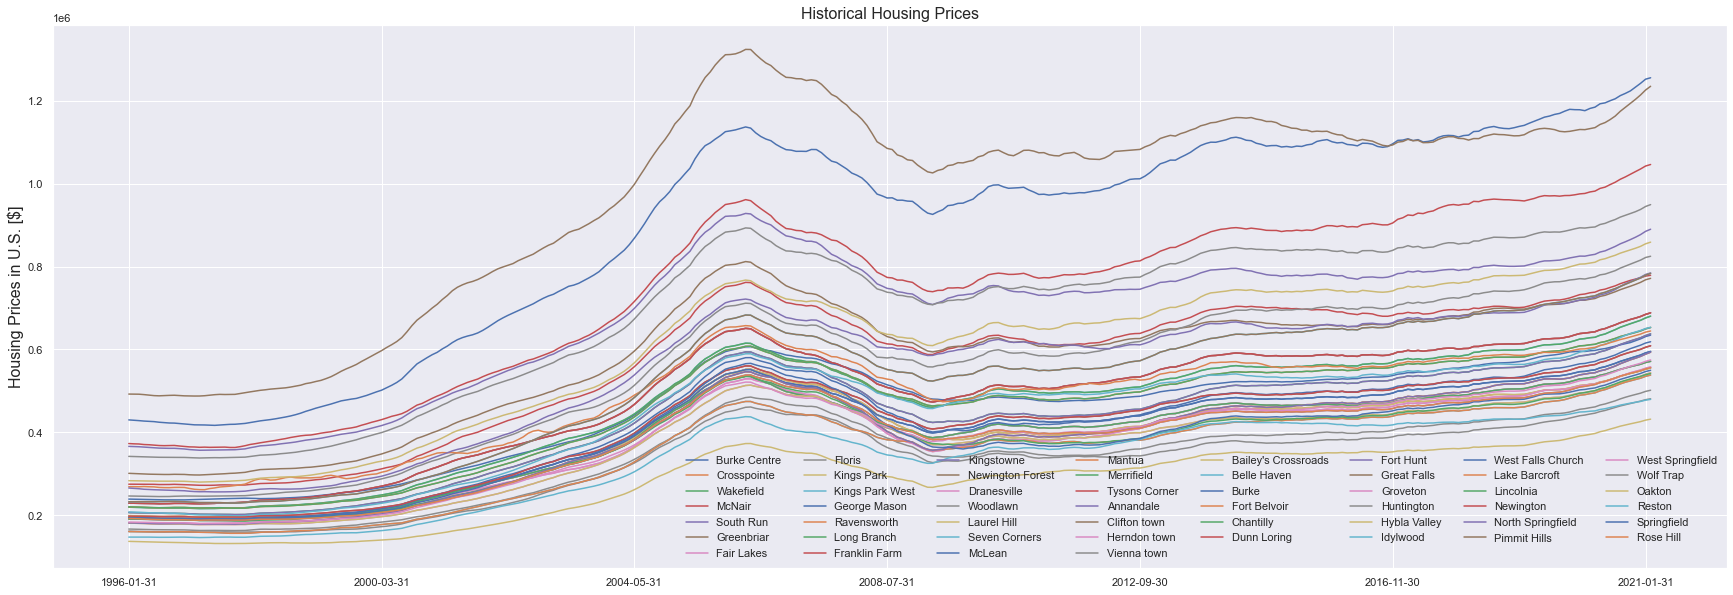

In [213]:
ax = plt.subplots(figsize = (30, 10))
for key, value in historical_prices.iterrows():
    ax = historical_prices.iloc[key, :].plot()

plt.title('Historical Housing Prices', fontsize=16)
plt.ylabel('Housing Prices in U.S. [$]', fontsize=16)
plt.grid(True)
label_hist_price = price_fairfax_merged.Neighborhoods
plt.legend(label_hist_price, frameon=False, loc='lower right', ncol=8)

#### We will choose the most recent housing price information in column '2021-02-28' to represents the average cost of a typical home in Fairfax County neighborhoods.   

##### For convenience, let's create a new dataframe with fewer columns

In [214]:
new_price_geo_data_fairfax = updated_new_price_fairfax[['Neighborhoods','Full_Address', 'Latitude', 'Longitude', 'Zipcode', 'StateName', 'CityName', 'CountyName', 'ForecastedDate', 'ForecastYoYPctChange', '2021-02-28']]
new_price_geo_data_fairfax.head()

Neighborhoods                                       Full_Address   Latitude  \
0  Burke Centre  Burke Centre, Fairfax County, Virginia, 22015-...  38.790992   
1   Crosspointe  Crosspointe, Laurel Hill, Fairfax County, Virg...  38.724002   
2     Wakefield  Wakefield Forest, Fairfax County, Virginia, 22...  38.835395   
3        McNair  McNair, Fairfax County, Virginia, 20171-3025, ...  38.952295   
4     South Run  South Run, Fairfax County, Virginia, 22039, Un...  38.747437   

   Longitude Zipcode StateName   CityName      CountyName ForecastedDate  \
0 -77.300519   22015        VA      Burke  Fairfax County     2022-02-28   
1 -77.265078   22079        VA     Lorton  Fairfax County     2022-02-28   
2 -77.239581   22003        VA  Annandale  Fairfax County     2022-02-28   
3 -77.414295   20171        VA    Herndon  Fairfax County     2022-02-28   
4 -77.281867   22039        VA     Lorton  Fairfax County     2022-02-28   

   ForecastYoYPctChange 2021-02-28  
0                   5.8   595250.0  
1                   5.8   555413.0  
2                   5.9   637630.0  
3                   5.7   688402.0  
4                   5.8   890128.0

##### Rename the '2021-02-28' columns to 'House_Price' and save it into a new dataframe

In [215]:
new_price_geo_data_fairfax.rename(columns = {'2021-02-28':'House_Price'}, inplace = True)
new_price_geo_data_fairfax.head()

c:\users\fomar\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Neighborhoods                                       Full_Address   Latitude  \
0  Burke Centre  Burke Centre, Fairfax County, Virginia, 22015-...  38.790992   
1   Crosspointe  Crosspointe, Laurel Hill, Fairfax County, Virg...  38.724002   
2     Wakefield  Wakefield Forest, Fairfax County, Virginia, 22...  38.835395   
3        McNair  McNair, Fairfax County, Virginia, 20171-3025, ...  38.952295   
4     South Run  South Run, Fairfax County, Virginia, 22039, Un...  38.747437   

   Longitude Zipcode StateName   CityName      CountyName ForecastedDate  \
0 -77.300519   22015        VA      Burke  Fairfax County     2022-02-28   
1 -77.265078   22079        VA     Lorton  Fairfax County     2022-02-28   
2 -77.239581   22003        VA  Annandale  Fairfax County     2022-02-28   
3 -77.414295   20171        VA    Herndon  Fairfax County     2022-02-28   
4 -77.281867   22039        VA     Lorton  Fairfax County     2022-02-28   

   ForecastYoYPctChange House_Price  
0                   5.8    595250.0  
1                   5.8    555413.0  
2                   5.9    637630.0  
3                   5.7    688402.0  
4                   5.8    890128.0

In [216]:
new_price_geo_data_fairfax.shape

(52, 11)

## 2.4 Import Foursquare Data

##### Thus far, we have generated a clean dataframe that contains a list of neighborhoods in Fairfax County, VA. The dataframe includes neighborhood names, full addresses, geo-spatial coordinates, forecasted change in housing prices, and most recent housing prices based on the data obtained from Zillow.
##### Our next task is to use the geo-spatial coordinates of each neighborhood and Foursquare API to obtain a list of venues within a certain radius of each neighborhood centers.

##### For convenience, let's create a new dataframe

In [217]:
new_fx_geo_location = new_price_geo_data_fairfax

In [218]:
#Define Foursquare Credentials and Version
#CLIENT_ID = 'your-client-ID' # your Foursquare ID
#CLIENT_SECRET = 'your-client-secret' # your Foursquare Secret

# For privacy reasons, I removed my Foursquare credentials.
CLIENT_ID = 'UUUUU5M3TZHWN1AHS2XKSJECFX1F3REMZH1T5UUUUUUUUU' # your Foursquare ID
CLIENT_SECRET = 'UUUUUUUNWX3YE0E5B0F55CYLWLLXSLUUUUUUUUUUUU' # your Foursquare Secret
ACCESS_TOKEN = 'UUUUUUUUYLV2IORIEUAJNPFYLFX1FIVUUUUUUUUUUUU' # your FourSquare Access Token

VERSION = '20210404' #'20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: 4HXFA35M3TZHWN1AHS2XKSJECFX1F3REMZH1T5SLOR2Y1OFW
CLIENT_SECRET:NN1N0I4KJY3ONWX3YE0E5B0F55CYLWLLXSLUZGNNOGZK2QQT


##### Explore one neighborhood 

In [219]:
neighborhood_index = 23
neighborhood_latitude = new_fx_geo_location.loc[neighborhood_index, 'Latitude'] # Tysons Corner neighborhood latitude value
neighborhood_longitude = new_fx_geo_location.loc[neighborhood_index, 'Longitude'] # Tysons Cormer neighborhood longitude value

neighborhood_name = new_fx_geo_location.loc[neighborhood_index, 'Neighborhoods'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Tysons Corner are 38.916509000000005, -77.22578585192836.


##### Create a Foursquare API query

In [220]:
LIMIT = 100
radius = 2000
#url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={}&v={},{}&radius={}&limit={}'.format(
# CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=4HXFA35M3TZHWN1AHS2XKSJECFX1F3REMZH1T5SLOR2Y1OFW&client_secret=NN1N0I4KJY3ONWX3YE0E5B0F55CYLWLLXSLUZGNNOGZK2QQT&v=20210404&ll=38.916509000000005,-77.22578585192836&radius=2000&limit=100'

In [221]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '606bdf31e9981a03cf3f253d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Tysons Corner',
  'headerFullLocation': 'Tysons Corner',
  'headerLocationGranularity': 'city',
  'totalResults': 171,
  'suggestedBounds': {'ne': {'lat': 38.93450901800002,
    'lng': -77.20269462550311},
   'sw': {'lat': 38.89850898199999, 'lng': -77.24887707835362}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4f626ea7e4b0ea77cba053b8',
       'name': 'CAVA',
       'location': {'address': '8048 Tysons Corner Ctr',
        'lat': 38.9171941,
        'lng': -77.2236294,
        'labeledLatLngs': [{'label': 'display',
        

## 3 Methodology

##### Define a function to extract the category of a venue

In [222]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

##### Now we are ready to clean the result of Foresquare API call (json) and structure it into a pandas dataframe for the selected venue.

In [223]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name                categories        lat        lng
0                 CAVA  Mediterranean Restaurant  38.917194 -77.223629
1            Nordstrom             Women's Store  38.916548 -77.222031
2  Apple Tysons Corner         Electronics Store  38.916893 -77.222998
3   The Capital Grille       American Restaurant  38.915805 -77.225477
4               &pizza               Pizza Place  38.916999 -77.223784

##### Check the number venues that were returned by Foursquare?

In [224]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


#### Explore Neighborhoods in Fairfax Virginia
##### Create a function to repeat the same process for all the neighborhoods in Fairfax County, Virginia

In [225]:
def getNearbyVenues(names, latitudes, longitudes, radius = 2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhoods', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

##### Write the code to run the above function for each neighborhood and create a new dataframe called fairfax_venues.

In [226]:
fairfax_venues = getNearbyVenues(names=new_fx_geo_location['Neighborhoods'],
                                   latitudes=new_fx_geo_location['Latitude'],
                                   longitudes=new_fx_geo_location['Longitude']
                                  )

Burke Centre
Crosspointe
Wakefield
McNair
South Run
Greenbriar
Fair Lakes
Floris
Kings Park
Kings Park West
George Mason
Ravensworth
Long Branch
Franklin Farm
Kingstowne
Newington Forest
Dranesville
Woodlawn
Laurel Hill
Seven Corners
McLean
Mantua
Merrifield
Tysons Corner
Annandale
Clifton town
Herndon town
Vienna town
Bailey's Crossroads
Belle Haven
Burke
Fort Belvoir
Chantilly
Dunn Loring
Fort Hunt
Great Falls
Groveton
Huntington
Hybla Valley
Idylwood
West Falls Church
Lake Barcroft
Lincolnia
Newington
North Springfield
Pimmit Hills
West Springfield
Wolf Trap
Oakton
Reston
Springfield
Rose Hill


##### Let's check the size of the resulting dataframe

In [227]:
print(fairfax_venues.shape)
fairfax_venues.head()

(3226, 7)


Neighborhoods  Neighborhood Latitude  Neighborhood Longitude  \
0  Burke Centre              38.790992              -77.300519   
1  Burke Centre              38.790992              -77.300519   
2  Burke Centre              38.790992              -77.300519   
3  Burke Centre              38.790992              -77.300519   
4  Burke Centre              38.790992              -77.300519   

                            Venue  Venue Latitude  Venue Longitude  \
0       burke racquet & swim club       38.788707       -77.296929   
1                   Fortune House       38.788285       -77.299924   
2  Villa Bella Italian Restaurant       38.788050       -77.301090   
3                         Dunkin'       38.787849       -77.301566   
4     Great Harvest Bread Company       38.788205       -77.299951   

         Venue Category  
0  Gym / Fitness Center  
1      Sushi Restaurant  
2           Pizza Place  
3            Donut Shop  
4                Bakery

##### Check how many venues were returned for each neighborhood

In [228]:
fairfax_venues.groupby('Neighborhoods').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhoods                                                               
Annandale                               90                      90     90   
Bailey's Crossroads                    100                     100    100   
Belle Haven                             95                      95     95   
Burke                                   46                      46     46   
Burke Centre                            54                      54     54   
Chantilly                               49                      49     49   
Clifton town                            16                      16     16   
Crosspointe                             35                      35     35   
Dranesville                             46                      46     46   
Dunn Loring                             81                      81     81   
Fair Lakes                              53                      53     53   
Floris                                  61                      61     61   
Fort Belvoir                            49                      49     49   
Fort Hunt                               23                      23     23   
Franklin Farm                           35                      35     35   
George Mason                            47                      47     47   
Great Falls                             23                      23     23   
Greenbriar                              86                      86     86   
Groveton                                87                      87     87   
Herndon town                           100                     100    100   
Huntington                             100                     100    100   
Hybla Valley                            78                      78     78   
Idylwood                                87                      87     87   
Kings Park                              33                      33     33   
Kings Park West                         37                      37     37   
Kingstowne                             100                     100    100   
Lake Barcroft                           76                      76     76   
Laurel Hill                             37                      37     37   
Lincolnia                               71                      71     71   
Long Branch                             36                      36     36   
Mantua                                  84                      84     84   
McLean                                  51                      51     51   
McNair                                  96                      96     96   
Merrifield                             100                     100    100   
Newington                               58                      58     58   
Newington Forest                        58                      58     58   
North Springfield                       22                      22     22   
Oakton                                  35                      35     35   
Pimmit Hills                           100                     100    100   
Ravensworth                             32                      32     32   
Reston                                 100                     100    100   
Rose Hill                               44                      44     44   
Seven Corners                          100                     100    100   
South Run                               19                      19     19   
Springfield                            100                     100    100   
Tysons Corner                          100                     100    100   
Vienna town                             93                      93     93   
Wakefield                               12                      12     12   
West Falls Church                       63                      63     63   
West Springfield                        47                      47     47   
Wolf Trap        

##### How many unique categories can be curated from all the returned venues?

In [229]:
print('There are {} uniques categories.'.format(len(fairfax_venues['Venue Category'].unique())))

There are 283 uniques categories.


In [230]:
fairfax_venues.shape

(3226, 7)

#### Analyzing each neighborhood

##### Perform one-hot encoding based on the venue category

In [231]:
fairfax_onehot = pd.get_dummies(fairfax_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
fairfax_onehot['Neighborhoods'] = fairfax_venues['Neighborhoods'] 

# move neighborhood column to the first column
fixed_columns = [fairfax_onehot.columns[-1]] + list(fairfax_onehot.columns[:-1])
fairfax_onehot = fairfax_onehot[fixed_columns]

fairfax_onehot.head()

Neighborhoods  ATM  Accessories Store  Advertising Agency  \
0  Burke Centre    0                  0                   0   
1  Burke Centre    0                  0                   0   
2  Burke Centre    0                  0                   0   
3  Burke Centre    0                  0                   0   
4  Burke Centre    0                  0                   0   

   Afghan Restaurant  Airport Service  American Restaurant  Antique Shop  \
0                  0                0                    0             0   
1                  0                0                    0             0   
2                  0                0                    0             0   
3                  0                0                    0             0   
4                  0                0                    0             0   

   Arcade  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0       0            0                    0                 0   
1       0            0                    0                 0   
2       0            0                    0                 0   
3       0            0                    0                 0   
4       0            0                    0                 0   

   Assisted Living  Athletics & Sports  Auto Garage  Automotive Shop  \
0                0                   0            0                0   
1                0                   0            0                0   
2                0                   0            0                0   
3                0                   0            0                0   
4                0                   0            0                0   

   BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  Beach  \
0          0           0       0     0    0               0      0   
1          0           0       0     0    0               0      0   
2          0           0       0     0    0               0      0   
3          0           0       0     0    0               0      0   
4          0           0       1     0    0               0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Big Box Store  Bike Shop  Bistro  \
0                0         0           0              0          0       0   
1                0         0           0              0          0       0   
2                0         0           0              0          0       0   
3                0         0           0              0          0       0   
4                0         0           0              0          0       0   

   Bookstore  Botanical Garden  Boutique  Bowling Alley  Brazilian Restaurant  \
0          0                 0         0              0                     0   
1          0                 0         0              0                     0   
2          0                 0         0              0                     0   
3          0                 0         0              0                     0   
4          0                 0         0              0                     0   

   Breakfast Spot  Brewery  Bubble Tea Shop  Buffet  Burger Joint  \
0               0        0                0       0             0   
1               0        0                0       0             0   
2               0        0                0       0             0   
3               0        0                0       0             0   
4               0        0                0       0             0   

   Bus Station  Business Service  Butcher  Cafeteria  Café  \
0            0                 0        0          0     0   
1            0                 0        0          0     0   
2            0                 0        0          0     0   
3            0                 0        0          0     0   
4            0                 0        0          0     0   

   Cajun / Creole Restaurant  Camera Store  Candy Store  Carpet Store  \
0                          0             0            0             0   
1                          0   

##### Let's examine the size of the new dataframe

In [232]:
fairfax_onehot.shape

(3226, 284)

##### Grouping rows by neighborhood and count the frequency of occurrence of each category

In [233]:
fairfax_grouped = fairfax_onehot.groupby('Neighborhoods').sum().reset_index()
fairfax_grouped.head()

Neighborhoods  ATM  Accessories Store  Advertising Agency  \
0            Annandale    0                  0                   0   
1  Bailey's Crossroads    0                  0                   0   
2          Belle Haven    0                  0                   0   
3                Burke    1                  0                   0   
4         Burke Centre    0                  0                   0   

   Afghan Restaurant  Airport Service  American Restaurant  Antique Shop  \
0                  0                0                    1             0   
1                  1                0                    3             0   
2                  0                0                    4             1   
3                  0                0                    1             0   
4                  0                0                    1             0   

   Arcade  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0       0            0                    0                 6   
1       0            0                    1                 1   
2       0            0                    0                 1   
3       0            0                    0                 2   
4       0            0                    1                 0   

   Assisted Living  Athletics & Sports  Auto Garage  Automotive Shop  \
0                0                   0            0                1   
1                0                   0            0                0   
2                0                   0            0                0   
3                0                   0            0                0   
4                0                   0            0                0   

   BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  Beach  \
0          0           0       5     2    0               0      0   
1          0           1       2     2    0               0      0   
2          1           0       3     3    0               0      0   
3          0           0       1     0    0               0      0   
4          0           0       1     2    0               0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Big Box Store  Bike Shop  Bistro  \
0                0         0           0              0          0       0   
1                0         0           0              1          1       0   
2                0         0           0              1          0       0   
3                0         0           0              0          0       0   
4                0         0           0              2          0       0   

   Bookstore  Botanical Garden  Boutique  Bowling Alley  Brazilian Restaurant  \
0          1                 0         0              1                     0   
1          0                 0         0              0                     0   
2          1                 0         0              0                     0   
3          0                 0         0              0                     0   
4          0                 0         0              1                     0   

   Breakfast Spot  Brewery  Bubble Tea Shop  Buffet  Burger Joint  \
0               0        0                2       0             1   
1               0        0                0       0             1   
2               0        0                0       0             1   
3               1        0                0       0             0   
4               1        0                0       0             1   

   Bus Station  Business Service  Butcher  Cafeteria  Café  \
0            0                 0        0          0     0   
1            0                 0        0          0     0   
2            0                 0        0          0     0   
3            1                 0        0          0     0   
4            0                 0        0          0     0   

   Cajun / Creole Restaurant  Camera Store  Candy Store  Carpet Store  \
0                          0             0            0             0

##### Confirm the size of the new dataframe

In [234]:
fairfax_grouped.shape

(52, 284)

##### Print each neighborhood along with the top 5 most common venues

In [235]:
num_top_venues = 5

for hood in fairfax_grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = fairfax_grouped[fairfax_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Annandale----
               venue  freq
0  Korean Restaurant  22.0
1   Asian Restaurant   6.0
2        Pizza Place   5.0
3             Bakery   5.0
4           Pharmacy   3.0


----Bailey's Crossroads----
                       venue  freq
0     Furniture / Home Store   3.0
1       Ethiopian Restaurant   3.0
2  Latin American Restaurant   3.0
3         Mexican Restaurant   3.0
4        American Restaurant   3.0


----Belle Haven----
                 venue  freq
0          Pizza Place   7.0
1                Hotel   5.0
2             Pharmacy   4.0
3  American Restaurant   4.0
4        Grocery Store   4.0


----Burke----
                  venue  freq
0           Pizza Place   5.0
1    Mexican Restaurant   3.0
2     Korean Restaurant   2.0
3  Gym / Fitness Center   2.0
4             Pet Store   2.0


----Burke Centre----
                  venue  freq
0           Coffee Shop   3.0
1    Mexican Restaurant   2.0
2         Big Box Store   2.0
3  Fast Food Restaurant   2.0
4              

##### Let's put the top 5 most common venues into a pandas dataframe, but first, let's write a function to sort the venues in descending order.

In [236]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#####  Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [237]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhoods'] = fairfax_grouped['Neighborhoods']

for ind in np.arange(fairfax_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(fairfax_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhoods 1st Most Common Venue 2nd Most Common Venue  \
0            Annandale     Korean Restaurant      Asian Restaurant   
1  Bailey's Crossroads  Ethiopian Restaurant           Coffee Shop   
2          Belle Haven           Pizza Place                 Hotel   
3                Burke           Pizza Place    Mexican Restaurant   
4         Burke Centre           Coffee Shop    Mexican Restaurant   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                Pizza Place                Bakery              Pharmacy   
1  Latin American Restaurant      Department Store   American Restaurant   
2              Grocery Store              Pharmacy   American Restaurant   
3       Fast Food Restaurant             Pet Store  Gym / Fitness Center   
4                Pizza Place        Sandwich Place         Big Box Store   

  6th Most Common Venue   7th Most Common Venue  \
0                  Park           Grocery Store   
1    Mexican Restaurant  Furniture / Home Store   
2     Convenience Store      Chinese Restaurant   
3     Korean Restaurant        Asian Restaurant   
4                   Gym                Pharmacy   

           8th Most Common Venue     9th Most Common Venue  \
0                Bubble Tea Shop         Convenience Store   
1                     Taco Place  Mediterranean Restaurant   
2                 Sandwich Place                Donut Shop   
3  Paper / Office Supplies Store                  Pharmacy   
4                 Gymnastics Gym                      Park   

  10th Most Common Venue  
0            Karaoke Bar  
1                 Bakery  
2                   Bank  
3         Discount Store  
4   Fast Food Restaurant

## 3.1 Clustering Neighborhoods

##### In this part, we will perform three clustering routines, using k-means algorithm. 
    1. Cluster neighborhoods based on venue categories
    2. Cluster neighborhoods based on housing prices
    3. Cluster neighborhoods based on forecasted change in the housing prices

#### Run k-means to cluster the neighborhood into 5 cluster based on venue category

###### Recal that we previously performed a one-hot encoding of the data based on Venue Category

In [238]:
# set number of clusters
kclusters = 5
fairfax_grouped_clustering = fairfax_grouped.drop('Neighborhoods', 1)
# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(fairfax_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30] 

array([4, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       3, 2, 2, 1, 2, 2, 1, 2])

##### Create a new dataframe that includes cluster labels and the top 10 venues for each neighborhood.

In [239]:
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_
neighborhoods_venues_sorted.head()

Neighborhoods 1st Most Common Venue 2nd Most Common Venue  \
0            Annandale     Korean Restaurant      Asian Restaurant   
1  Bailey's Crossroads  Ethiopian Restaurant           Coffee Shop   
2          Belle Haven           Pizza Place                 Hotel   
3                Burke           Pizza Place    Mexican Restaurant   
4         Burke Centre           Coffee Shop    Mexican Restaurant   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                Pizza Place                Bakery              Pharmacy   
1  Latin American Restaurant      Department Store   American Restaurant   
2              Grocery Store              Pharmacy   American Restaurant   
3       Fast Food Restaurant             Pet Store  Gym / Fitness Center   
4                Pizza Place        Sandwich Place         Big Box Store   

  6th Most Common Venue   7th Most Common Venue  \
0                  Park           Grocery Store   
1    Mexican Restaurant  Furniture / Home Store   
2     Convenience Store      Chinese Restaurant   
3     Korean Restaurant        Asian Restaurant   
4                   Gym                Pharmacy   

           8th Most Common Venue     9th Most Common Venue  \
0                Bubble Tea Shop         Convenience Store   
1                     Taco Place  Mediterranean Restaurant   
2                 Sandwich Place                Donut Shop   
3  Paper / Office Supplies Store                  Pharmacy   
4                 Gymnastics Gym                      Park   

  10th Most Common Venue  Cluster Labels  
0            Karaoke Bar               4  
1                 Bakery               1  
2                   Bank               1  
3         Discount Store               1  
4   Fast Food Restaurant               2

In [240]:
# Create a temporary dataframe
temp_data_venue = neighborhoods_venues_sorted[['Neighborhoods','Cluster Labels'] ]
temp_data_venue.head()

Neighborhoods  Cluster Labels
0            Annandale               4
1  Bailey's Crossroads               1
2          Belle Haven               1
3                Burke               1
4         Burke Centre               2

##### Merge neighborhoods dataframe with top ten venues and cluster labels into one dataframe

In [241]:
#fairfax_merged = new_price_geo_data_fairfax.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Neighborhoods')
fairfax_merged = new_price_geo_data_fairfax.join(temp_data_venue.set_index('Neighborhoods'), on='Neighborhoods')
print(fairfax_merged.shape)
fairfax_merged.head() # check the last columns!

(52, 12)


Neighborhoods                                       Full_Address   Latitude  \
0  Burke Centre  Burke Centre, Fairfax County, Virginia, 22015-...  38.790992   
1   Crosspointe  Crosspointe, Laurel Hill, Fairfax County, Virg...  38.724002   
2     Wakefield  Wakefield Forest, Fairfax County, Virginia, 22...  38.835395   
3        McNair  McNair, Fairfax County, Virginia, 20171-3025, ...  38.952295   
4     South Run  South Run, Fairfax County, Virginia, 22039, Un...  38.747437   

   Longitude Zipcode StateName   CityName      CountyName ForecastedDate  \
0 -77.300519   22015        VA      Burke  Fairfax County     2022-02-28   
1 -77.265078   22079        VA     Lorton  Fairfax County     2022-02-28   
2 -77.239581   22003        VA  Annandale  Fairfax County     2022-02-28   
3 -77.414295   20171        VA    Herndon  Fairfax County     2022-02-28   
4 -77.281867   22039        VA     Lorton  Fairfax County     2022-02-28   

   ForecastYoYPctChange House_Price  Cluster Labels  
0                   5.8    595250.0               2  
1                   5.8    555413.0               2  
2                   5.9    637630.0               2  
3                   5.7    688402.0               1  
4                   5.8    890128.0               2

##### Clean the datafram and drop neighborhoods with na entries, if exists after the merge

In [242]:
updated_fairfax_merged = fairfax_merged.dropna()
updated_fairfax_merged = updated_fairfax_merged.reset_index(drop = True)
print(updated_fairfax_merged.shape)
updated_fairfax_merged.head()

(52, 12)


Neighborhoods                                       Full_Address   Latitude  \
0  Burke Centre  Burke Centre, Fairfax County, Virginia, 22015-...  38.790992   
1   Crosspointe  Crosspointe, Laurel Hill, Fairfax County, Virg...  38.724002   
2     Wakefield  Wakefield Forest, Fairfax County, Virginia, 22...  38.835395   
3        McNair  McNair, Fairfax County, Virginia, 20171-3025, ...  38.952295   
4     South Run  South Run, Fairfax County, Virginia, 22039, Un...  38.747437   

   Longitude Zipcode StateName   CityName      CountyName ForecastedDate  \
0 -77.300519   22015        VA      Burke  Fairfax County     2022-02-28   
1 -77.265078   22079        VA     Lorton  Fairfax County     2022-02-28   
2 -77.239581   22003        VA  Annandale  Fairfax County     2022-02-28   
3 -77.414295   20171        VA    Herndon  Fairfax County     2022-02-28   
4 -77.281867   22039        VA     Lorton  Fairfax County     2022-02-28   

   ForecastYoYPctChange House_Price  Cluster Labels  
0                   5.8    595250.0               2  
1                   5.8    555413.0               2  
2                   5.9    637630.0               2  
3                   5.7    688402.0               1  
4                   5.8    890128.0               2

##### Visualize the resulting clusters based on venue category

In [243]:
fairfax_county_latitude = 38.9085
fairfax_county_longitude = -77.2405
# create map
fairfax_map_clusters = folium.Map(location=[fairfax_county_latitude, fairfax_county_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add the borders onto the the map_fairfax
folium.GeoJson(
    fairfax_geo_json_data,
    style_function=lambda feature: {
        "fillColor": "#a89732",
        "color": "black",
        "weight": 2,
        "dashArray": "5, 5",
    },
).add_to(fairfax_map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(updated_fairfax_merged['Latitude'], updated_fairfax_merged['Longitude'], updated_fairfax_merged['Neighborhoods'], updated_fairfax_merged['Cluster Labels']):

    label = folium.Popup(str(poi) + ' Cluster '+ str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(fairfax_map_clusters)
       
fairfax_map_clusters

#### Analyze each cluster based on venue categories

#### Cluster 1 - Venue Category

In [244]:
cluster1_venue_category = updated_fairfax_merged.loc[updated_fairfax_merged['Cluster Labels'] == 0, updated_fairfax_merged.columns[[0] + list(range(5, updated_fairfax_merged.shape[1]))]]
cluster1_venue_category

Neighborhoods StateName      CityName      CountyName ForecastedDate  \
19  Seven Corners        VA  Falls Church  Fairfax County     2022-02-28   

    ForecastYoYPctChange House_Price  Cluster Labels  
19                   6.1    538331.0               0

#### Create a bar plot of forecasted percentage price change and housing prices

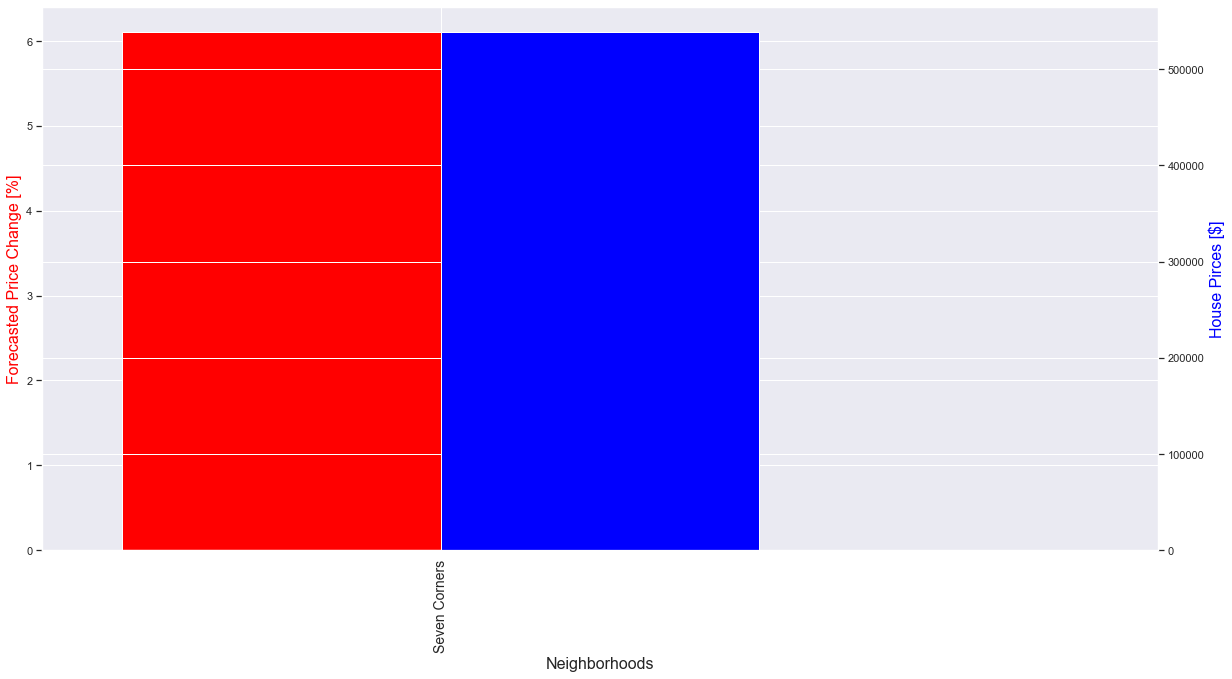

In [245]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax2 = ax.twinx()

width = 0.2
cluster1_venue_category.ForecastYoYPctChange.plot(kind='bar', color='red', ax=ax, width=width, position=1)
cluster1_venue_category.House_Price.astype(float).plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Forecasted Price Change [%]', color="red",fontsize=16)

ax2.set_ylabel('House Pirces [$]', color="blue",fontsize=16)
ax.set_xlabel('Neighborhoods', fontsize=16)
ax.set_xticklabels(cluster1_venue_category.Neighborhoods, fontsize=14)
plt.show()

#### Cluster 2 - Venue Category

In [246]:
cluster2_venue_category = updated_fairfax_merged.loc[updated_fairfax_merged['Cluster Labels'] == 1, updated_fairfax_merged.columns[[0] + list(range(5, updated_fairfax_merged.shape[1]))]]
cluster2_venue_category.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster2_venue_category

Neighborhoods StateName      CityName      CountyName  \
27          Vienna town        VA        Vienna  Fairfax County   
22           Merrifield        VA       Fairfax  Fairfax County   
3                McNair        VA       Herndon  Fairfax County   
38         Hybla Valley        VA  Hybla Valley  Fairfax County   
37           Huntington        VA    Huntington  Fairfax County   
36             Groveton        VA  Hybla Valley  Fairfax County   
30                Burke        VA         Burke  Fairfax County   
49               Reston        VA        Reston  Fairfax County   
50          Springfield        VA   Springfield  Fairfax County   
5            Greenbriar        VA       Fairfax  Fairfax County   
26         Herndon town        VA       Herndon  Fairfax County   
15     Newington Forest        VA   Springfield  Fairfax County   
14           Kingstowne        VA     Rose Hill  Fairfax County   
43            Newington        VA   Springfield  Fairfax County   
42            Lincolnia        VA     Lincolnia  Fairfax County   
29          Belle Haven        VA   Belle Haven  Fairfax County   
17             Woodlawn        VA  Mount Vernon  Fairfax County   
28  Bailey's Crossroads        VA  Falls Church  Fairfax County   

   ForecastedDate  ForecastYoYPctChange House_Price  Cluster Labels  
27     2022-02-28                   5.4    824915.0               1  
22     2022-02-28                   5.6    653093.0               1  
3      2022-02-28                   5.7    688402.0               1  
38     2022-02-28                   5.8    543755.0               1  
37     2022-02-28                   5.8    481086.0               1  
36     2022-02-28                   5.8    543755.0               1  
30     2022-02-28                   5.8    595250.0               1  
49     2022-02-28                   5.8    479682.0               1  
50     2022-02-28                   5.8    549804.0               1  
5      2022-02-28                   5.8    571477.0               1  
26     2022-02-28                   5.8    557876.0               1  
15     2022-02-28                   5.9    608921.0               1  
14     2022-02-28                   5.9    555972.0               1  
43     2022-02-28                   5.9    608921.0               1  
42     2022-02-28                   6.0    541869.0               1  
29     2022-02-28                   6.1    653496.0               1  
17     2022-02-28                   6.1    501693.0               1  
28     2022-02-28                   6.1    431954.0               1

#### Create a bar plot of forecasted percentage price change and housing prices

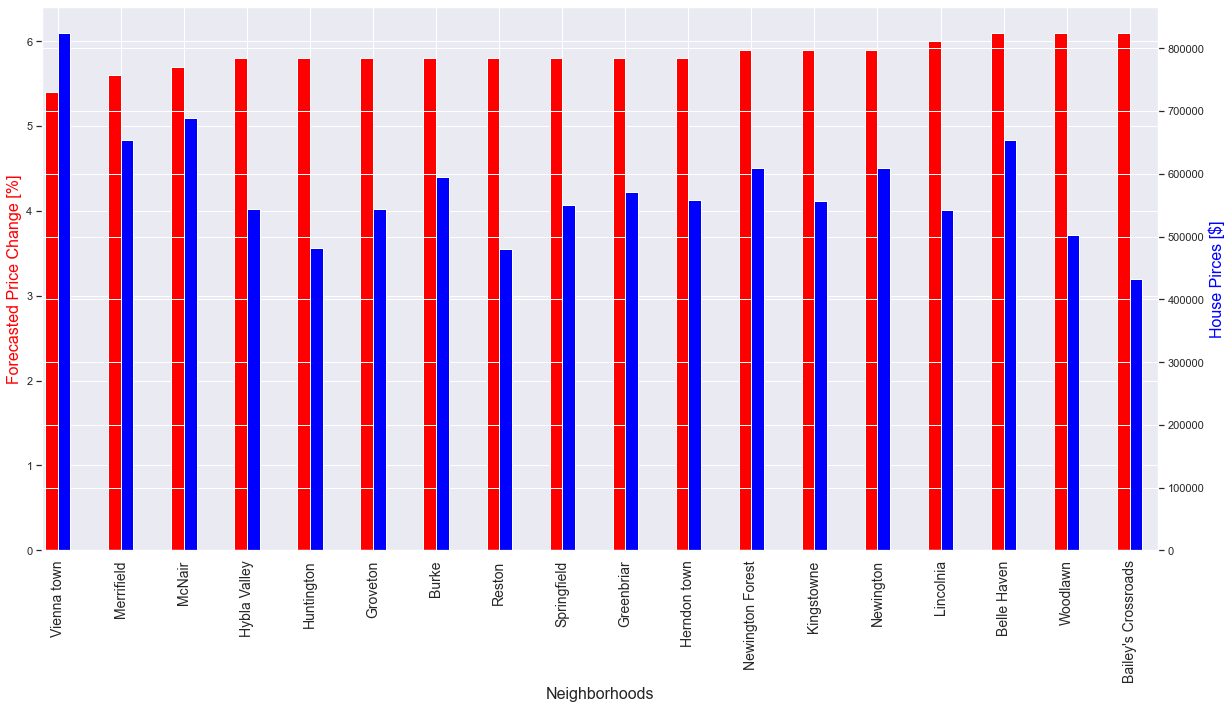

In [247]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax2 = ax.twinx()

width = 0.2
cluster2_venue_category.ForecastYoYPctChange.plot(kind='bar', color='red', ax=ax, width=width, position=1)
cluster2_venue_category.House_Price.astype(float).plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Forecasted Price Change [%]', color="red",fontsize=16)

ax2.set_ylabel('House Pirces [$]', color="blue",fontsize=16)
ax.set_xlabel('Neighborhoods', fontsize=16)
ax.set_xticklabels(cluster2_venue_category.Neighborhoods, fontsize=14)
plt.show()

#### Cluster 3 - Venue Category

In [248]:
cluster3_venue_category = updated_fairfax_merged.loc[updated_fairfax_merged['Cluster Labels'] == 2, updated_fairfax_merged.columns[[0] + list(range(5, updated_fairfax_merged.shape[1]))]]
cluster3_venue_category.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster3_venue_category

Neighborhoods StateName      CityName      CountyName ForecastedDate  \
33        Dunn Loring        VA   Dunn Loring  Fairfax County     2022-02-28   
10       George Mason        VA       Fairfax  Fairfax County     2022-02-28   
20             McLean        VA        McLean  Fairfax County     2022-02-28   
47          Wolf Trap        VA        Vienna  Fairfax County     2022-02-28   
31       Fort Belvoir        VA  Fort Belvoir  Fairfax County     2022-02-28   
48             Oakton        VA        Vienna  Fairfax County     2022-02-28   
25       Clifton town        VA       Clifton  Fairfax County     2022-02-28   
21             Mantua        VA       Fairfax  Fairfax County     2022-02-28   
34          Fort Hunt        VA     Fort Hunt  Fairfax County     2022-02-28   
7              Floris        VA       Herndon  Fairfax County     2022-02-28   
13      Franklin Farm        VA       Herndon  Fairfax County     2022-02-28   
46   West Springfield        VA   Springfield  Fairfax County     2022-02-28   
35        Great Falls        VA   Great Falls  Fairfax County     2022-02-28   
32          Chantilly        VA       Fairfax  Fairfax County     2022-02-28   
0        Burke Centre        VA         Burke  Fairfax County     2022-02-28   
16        Dranesville        VA       Herndon  Fairfax County     2022-02-28   
6          Fair Lakes        VA       Fairfax  Fairfax County     2022-02-28   
4           South Run        VA        Lorton  Fairfax County     2022-02-28   
1         Crosspointe        VA        Lorton  Fairfax County     2022-02-28   
18        Laurel Hill        VA        Lorton  Fairfax County     2022-02-28   
12        Long Branch        VA       Fairfax  Fairfax County     2022-02-28   
9     Kings Park West        VA       Fairfax  Fairfax County     2022-02-28   
40  West Falls Church        VA  Falls Church  Fairfax County     2022-02-28   
2           Wakefield        VA     Annandale  Fairfax County     2022-02-28   
51          Rose Hill        VA     Rose Hill  Fairfax County     2022-02-28   
11        Ravensworth        VA   Springfield  Fairfax County     2022-02-28   
8          Kings Park        VA   Springfield  Fairfax County     2022-02-28   
44  North Springfield        VA   Springfield  Fairfax County     2022-02-28   
41      Lake Barcroft        VA  Falls Church  Fairfax County     2022-02-28   

    ForecastYoYPctChange House_Price  Cluster Labels  
33                   5.1   1046272.0               2  
10                   5.2    634644.0               2  
20                   5.3   1255540.0               2  
47                   5.4    949536.0               2  
31                   5.4    644641.0               2  
48                   5.5    858957.0               2  
25                   5.6    771612.0               2  
21                   5.6    653093.0               2  
34                   5.7    784641.0               2  
7                    5.7    688402.0               2  
13                   5.7    688402.0               2  
46                   5.8    574793.0               2  
35                   5.8   1234994.0               2  
32                   5.8    571477.0               2  
0                    5.8    595250.0               2  
16                   5.8    557876.0               2  
6                    5.8    571477.0               2  
4                    5.8    890128.0               2  
1                    5.8    555413.0               2  
18                   5.8    555413.0               2  
12                   5.9    680395.0               2  
9                    5.9    680395.0               2  
40                   5.9    618723.0               2  
2                    5.9    637630.0               2  
51                   5.9    555972.0               2  
11                   6.0    593580.0               2  
8                    6.0    593580.0               2  
44                   6.0    593580.0               2  
41          

#### Create a bar plot of forecasted percentage price change and housing prices

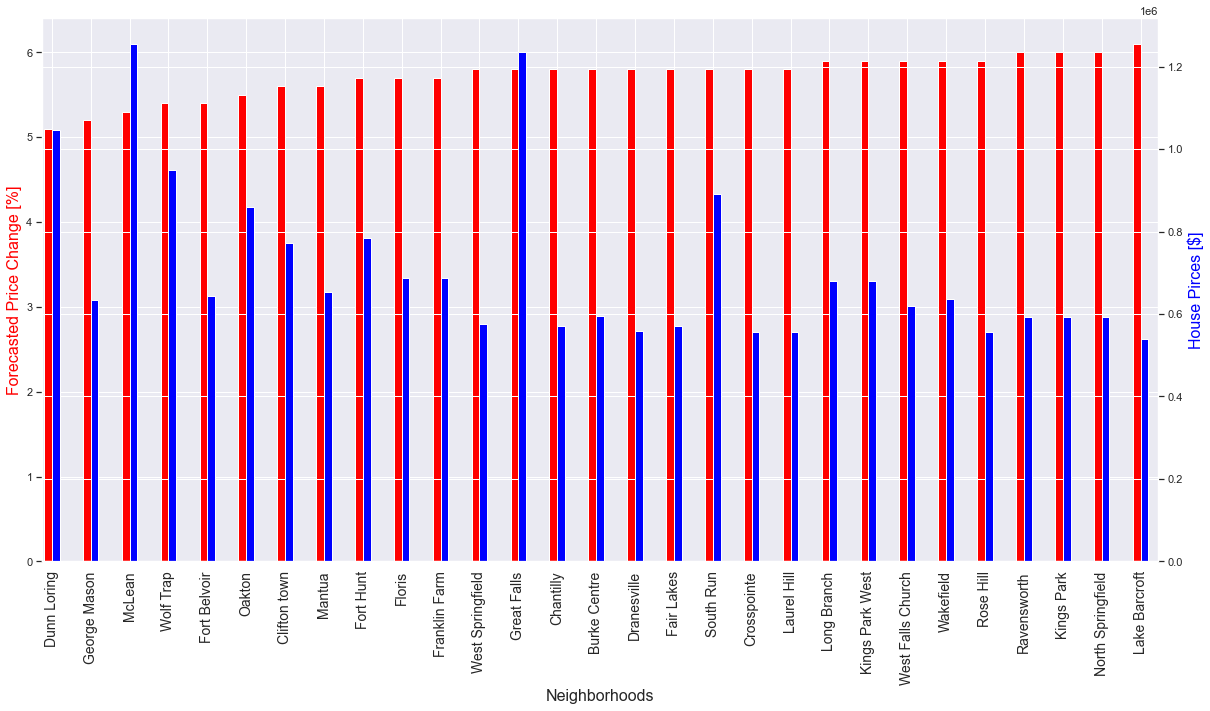

In [249]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax2 = ax.twinx()

width = 0.2
cluster3_venue_category.ForecastYoYPctChange.plot(kind='bar', color='red', ax=ax, width=width, position=1)
cluster3_venue_category.House_Price.astype(float).plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Forecasted Price Change [%]', color="red",fontsize=16)

ax2.set_ylabel('House Pirces [$]', color="blue",fontsize=16)
ax.set_xlabel('Neighborhoods', fontsize=16)
ax.set_xticklabels(cluster3_venue_category.Neighborhoods, fontsize=14)
plt.show()

#### Cluster 4 - Venue Category

In [250]:
cluster4_venue_category = updated_fairfax_merged.loc[updated_fairfax_merged['Cluster Labels'] == 3, updated_fairfax_merged.columns[[0] + list(range(5, updated_fairfax_merged.shape[1]))]]
cluster4_venue_category.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster4_venue_category

Neighborhoods StateName      CityName      CountyName ForecastedDate  \
39       Idylwood        VA  Falls Church  Fairfax County     2022-02-28   
45   Pimmit Hills        VA  Falls Church  Fairfax County     2022-02-28   
23  Tysons Corner        VA        McLean  Fairfax County     2022-02-28   

    ForecastYoYPctChange House_Price  Cluster Labels  
39                   5.6    783622.0               3  
45                   5.6    783622.0               3  
23                   5.7    779114.0               3

#### Cluster 5 - Venue Category

In [251]:
cluster5_venue_category = updated_fairfax_merged.loc[updated_fairfax_merged['Cluster Labels'] == 4, updated_fairfax_merged.columns[[0] + list(range(5, updated_fairfax_merged.shape[1]))]]
cluster5_venue_category.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster5_venue_category

Neighborhoods StateName   CityName      CountyName ForecastedDate  \
24     Annandale        VA  Annandale  Fairfax County     2022-02-28   

    ForecastYoYPctChange House_Price  Cluster Labels  
24                   5.9    637630.0               4

#### Create a bar plot of forecasted percentage price change and housing prices

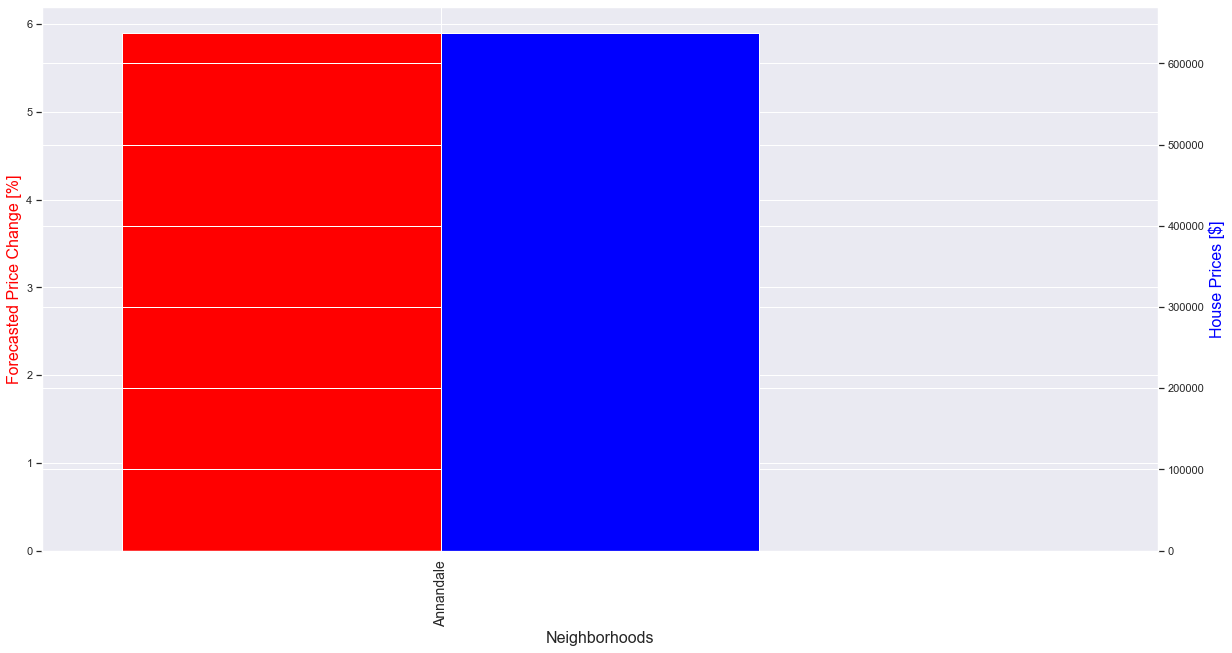

In [252]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax2 = ax.twinx()

width = 0.2
cluster5_venue_category.ForecastYoYPctChange.plot(kind='bar', color='red', ax=ax, width=width, position=1)
cluster5_venue_category.House_Price.astype(float).plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Forecasted Price Change [%]', color="red",fontsize=16)

ax2.set_ylabel('House Prices [$]', color="blue",fontsize=16)
ax.set_xlabel('Neighborhoods', fontsize=16)
ax.set_xticklabels(cluster5_venue_category.Neighborhoods, fontsize=14)
plt.show()

#### Run k-means to cluster the neighborhood into 5 cluster based on House Price

##### Create a new dataframe for running k-mean clustering algorithm based housing prices

In [253]:
cluster_house_price_df = fairfax_merged[['Neighborhoods', 'Latitude', 'Longitude','House_Price','ForecastYoYPctChange']].copy()
cluster_house_price_df.head()

Neighborhoods   Latitude  Longitude House_Price  ForecastYoYPctChange
0  Burke Centre  38.790992 -77.300519    595250.0                   5.8
1   Crosspointe  38.724002 -77.265078    555413.0                   5.8
2     Wakefield  38.835395 -77.239581    637630.0                   5.9
3        McNair  38.952295 -77.414295    688402.0                   5.7
4     South Run  38.747437 -77.281867    890128.0                   5.8

##### Perform one-hot encoding, using housing price data

In [254]:
fairfax_onehot_house_price = pd.get_dummies(cluster_house_price_df[['House_Price']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
fairfax_onehot_house_price['Neighborhoods'] = cluster_house_price_df['Neighborhoods'] 

# move neighborhood column to the first column
fixed_columns_test = [fairfax_onehot_house_price.columns[-1]] + list(fairfax_onehot_house_price.columns[:-1])
fairfax_onehot_house_price = fairfax_onehot_house_price[fixed_columns_test]

fairfax_onehot_house_price.head()

Neighborhoods  1046272.0  1234994.0  1255540.0  431954.0  479682.0  \
0  Burke Centre          0          0          0         0         0   
1   Crosspointe          0          0          0         0         0   
2     Wakefield          0          0          0         0         0   
3        McNair          0          0          0         0         0   
4     South Run          0          0          0         0         0   

   481086.0  501693.0  538331.0  541869.0  543755.0  549804.0  555413.0  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         1   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   555972.0  557876.0  571477.0  574793.0  593580.0  595250.0  608921.0  \
0         0         0         0         0         0         1         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   618723.0  634644.0  637630.0  644641.0  653093.0  653496.0  680395.0  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         1         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   688402.0  771612.0  779114.0  783622.0  784641.0  824915.0  858957.0  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         1         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   890128.0  949536.0  
0         0         0  
1         0         0  
2         0         0  
3         0         0  
4         1         0

In [255]:
# set number of clusters
kclusters = 5

fairfax_grouped_clustering_house_price = fairfax_onehot_house_price.drop('Neighborhoods', 1)
#fairfax_grouped_clustering_test = fairfax_onehot_test.drop('Neighborhoods', 1)
# run k-means clustering
kmeans_test = KMeans(n_clusters = kclusters, random_state = 0).fit(fairfax_grouped_clustering_house_price)

# check cluster labels generated for each row in the dataframe
kmeans_test.labels_[0:30] 

array([0, 0, 0, 2, 0, 1, 1, 2, 4, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

##### Create the 'Cluster Label' column and add the labels to the dataframe

In [256]:
cluster_house_price_df['Cluster Labels'] = kmeans_test.labels_
cluster_house_price_df.head()

Neighborhoods   Latitude  Longitude House_Price  ForecastYoYPctChange  \
0  Burke Centre  38.790992 -77.300519    595250.0                   5.8   
1   Crosspointe  38.724002 -77.265078    555413.0                   5.8   
2     Wakefield  38.835395 -77.239581    637630.0                   5.9   
3        McNair  38.952295 -77.414295    688402.0                   5.7   
4     South Run  38.747437 -77.281867    890128.0                   5.8   

   Cluster Labels  
0               0  
1               0  
2               0  
3               2  
4               0

##### Make a copy of neighborhoods and cluster labels

In [257]:
new_cluster_house_price_df = cluster_house_price_df[['Neighborhoods', 'Cluster Labels']].copy()
new_cluster_house_price_df.head()

Neighborhoods  Cluster Labels
0  Burke Centre               0
1   Crosspointe               0
2     Wakefield               0
3        McNair               2
4     South Run               0

##### Create a new dataframe and add cluster labels

In [258]:
fairfax_merged_house_price_df = new_price_geo_data_fairfax 
fairfax_merged_house_price_df = fairfax_merged_house_price_df.join(new_cluster_house_price_df.set_index('Neighborhoods'), on='Neighborhoods')

fairfax_merged_house_price_df.head() # check the first columns!

Neighborhoods                                       Full_Address   Latitude  \
0  Burke Centre  Burke Centre, Fairfax County, Virginia, 22015-...  38.790992   
1   Crosspointe  Crosspointe, Laurel Hill, Fairfax County, Virg...  38.724002   
2     Wakefield  Wakefield Forest, Fairfax County, Virginia, 22...  38.835395   
3        McNair  McNair, Fairfax County, Virginia, 20171-3025, ...  38.952295   
4     South Run  South Run, Fairfax County, Virginia, 22039, Un...  38.747437   

   Longitude Zipcode StateName   CityName      CountyName ForecastedDate  \
0 -77.300519   22015        VA      Burke  Fairfax County     2022-02-28   
1 -77.265078   22079        VA     Lorton  Fairfax County     2022-02-28   
2 -77.239581   22003        VA  Annandale  Fairfax County     2022-02-28   
3 -77.414295   20171        VA    Herndon  Fairfax County     2022-02-28   
4 -77.281867   22039        VA     Lorton  Fairfax County     2022-02-28   

   ForecastYoYPctChange House_Price  Cluster Labels  
0                   5.8    595250.0               0  
1                   5.8    555413.0               0  
2                   5.9    637630.0               0  
3                   5.7    688402.0               2  
4                   5.8    890128.0               0

##### Let's visualize the resulting clusters based on house price

In [259]:
fairfax_county_latitude = 38.9085
fairfax_county_longitude = -77.2405
# create map
fairfax_map_clusters_house_price = folium.Map(location=[fairfax_county_latitude, fairfax_county_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add the borders onto the the map_fairfax
folium.GeoJson(
    fairfax_geo_json_data,
    style_function=lambda feature: {
        "fillColor": "#a89732",
        "color": "black",
        "weight": 2,
        "dashArray": "5, 5",
    },
).add_to(fairfax_map_clusters_house_price)


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(fairfax_merged_house_price_df['Latitude'], fairfax_merged_house_price_df['Longitude'], fairfax_merged_house_price_df['Neighborhoods'], fairfax_merged_house_price_df['Cluster Labels']):

    label = folium.Popup(str(poi) + ' Cluster '+ str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(fairfax_map_clusters_house_price)
       
fairfax_map_clusters_house_price

#### Let's analyze each cluster based on housing prices 

#### Cluster 1 - House Price

In [260]:
cluster1_house_price = fairfax_merged_house_price_df.loc[fairfax_merged_house_price_df['Cluster Labels'] == 0, fairfax_merged_house_price_df.columns[[0] + list(range(5, fairfax_merged_house_price_df.shape[1]))]]
cluster1_house_price.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster1_house_price

Neighborhoods StateName      CityName      CountyName  \
33          Dunn Loring        VA   Dunn Loring  Fairfax County   
10         George Mason        VA       Fairfax  Fairfax County   
20               McLean        VA        McLean  Fairfax County   
27          Vienna town        VA        Vienna  Fairfax County   
47            Wolf Trap        VA        Vienna  Fairfax County   
31         Fort Belvoir        VA  Fort Belvoir  Fairfax County   
48               Oakton        VA        Vienna  Fairfax County   
45         Pimmit Hills        VA  Falls Church  Fairfax County   
39             Idylwood        VA  Falls Church  Fairfax County   
22           Merrifield        VA       Fairfax  Fairfax County   
25         Clifton town        VA       Clifton  Fairfax County   
21               Mantua        VA       Fairfax  Fairfax County   
23        Tysons Corner        VA        McLean  Fairfax County   
34            Fort Hunt        VA     Fort Hunt  Fairfax County   
30                Burke        VA         Burke  Fairfax County   
35          Great Falls        VA   Great Falls  Fairfax County   
46     West Springfield        VA   Springfield  Fairfax County   
49               Reston        VA        Reston  Fairfax County   
37           Huntington        VA    Huntington  Fairfax County   
50          Springfield        VA   Springfield  Fairfax County   
0          Burke Centre        VA         Burke  Fairfax County   
1           Crosspointe        VA        Lorton  Fairfax County   
4             South Run        VA        Lorton  Fairfax County   
18          Laurel Hill        VA        Lorton  Fairfax County   
16          Dranesville        VA       Herndon  Fairfax County   
26         Herndon town        VA       Herndon  Fairfax County   
40    West Falls Church        VA  Falls Church  Fairfax County   
2             Wakefield        VA     Annandale  Fairfax County   
9       Kings Park West        VA       Fairfax  Fairfax County   
12          Long Branch        VA       Fairfax  Fairfax County   
43            Newington        VA   Springfield  Fairfax County   
51            Rose Hill        VA     Rose Hill  Fairfax County   
14           Kingstowne        VA     Rose Hill  Fairfax County   
15     Newington Forest        VA   Springfield  Fairfax County   
24            Annandale        VA     Annandale  Fairfax County   
42            Lincolnia        VA     Lincolnia  Fairfax County   
17             Woodlawn        VA  Mount Vernon  Fairfax County   
19        Seven Corners        VA  Falls Church  Fairfax County   
29          Belle Haven        VA   Belle Haven  Fairfax County   
41        Lake Barcroft        VA  Falls Church  Fairfax County   
28  Bailey's Crossroads        VA  Falls Church  Fairfax County   

   ForecastedDate  ForecastYoYPctChange House_Price  Cluster Labels  
33     2022-02-28                   5.1   1046272.0               0  
10     2022-02-28                   5.2    634644.0               0  
20     2022-02-28                   5.3   1255540.0               0  
27     2022-02-28                   5.4    824915.0               0  
47     2022-02-28                   5.4    949536.0               0  
31     2022-02-28                   5.4    644641.0               0  
48     2022-02-28                   5.5    858957.0               0  
45     2022-02-28                   5.6    783622.0               0  
39     2022-02-28                   5.6    783622.0               0  
22     2022-02-28                   5.6    653093.0               0  
25     2022-02-28                   5.6    771612.0               0  
21     2022-02-28                   5.6    653093.0               0  
23     2022-02-28                   5.7    779114.0               0  
34     2022-02-28                   5.7    784641.0               0  
30     2022-02-28                   5.8    595250.0               0  
35     2022-02-28                   5.8   1234994.0               0  
46   

#### Create a bar plot of forecasted percentage price change and housing prices

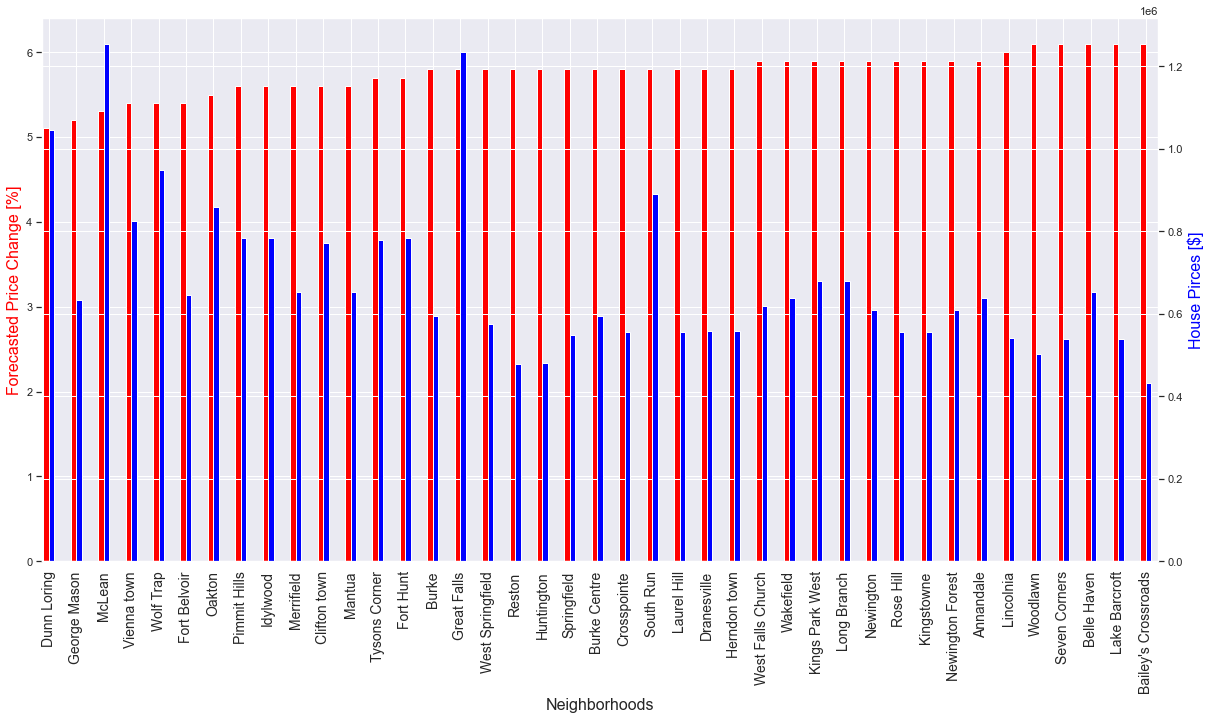

In [261]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax2 = ax.twinx()

width = 0.2
cluster1_house_price.ForecastYoYPctChange.plot(kind='bar', color='red', ax=ax, width=width, position=1)
cluster1_house_price.House_Price.astype(float).plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Forecasted Price Change [%]', color="red",fontsize=16)

ax2.set_ylabel('House Pirces [$]', color="blue",fontsize=16)
ax.set_xlabel('Neighborhoods', fontsize=16)
ax.set_xticklabels(cluster1_house_price.Neighborhoods, fontsize=14)
plt.show()

#### Cluster 2 - House Price

In [262]:
cluster2_house_price = fairfax_merged_house_price_df.loc[fairfax_merged_house_price_df['Cluster Labels'] == 1, fairfax_merged_house_price_df.columns[[0] + list(range(5, fairfax_merged_house_price_df.shape[1]))]]
cluster2_house_price.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster2_house_price

Neighborhoods StateName CityName      CountyName ForecastedDate  \
5     Greenbriar        VA  Fairfax  Fairfax County     2022-02-28   
6     Fair Lakes        VA  Fairfax  Fairfax County     2022-02-28   
32     Chantilly        VA  Fairfax  Fairfax County     2022-02-28   

    ForecastYoYPctChange House_Price  Cluster Labels  
5                    5.8    571477.0               1  
6                    5.8    571477.0               1  
32                   5.8    571477.0               1

#### Create a bar plot of forecasted percentage price change and housing prices

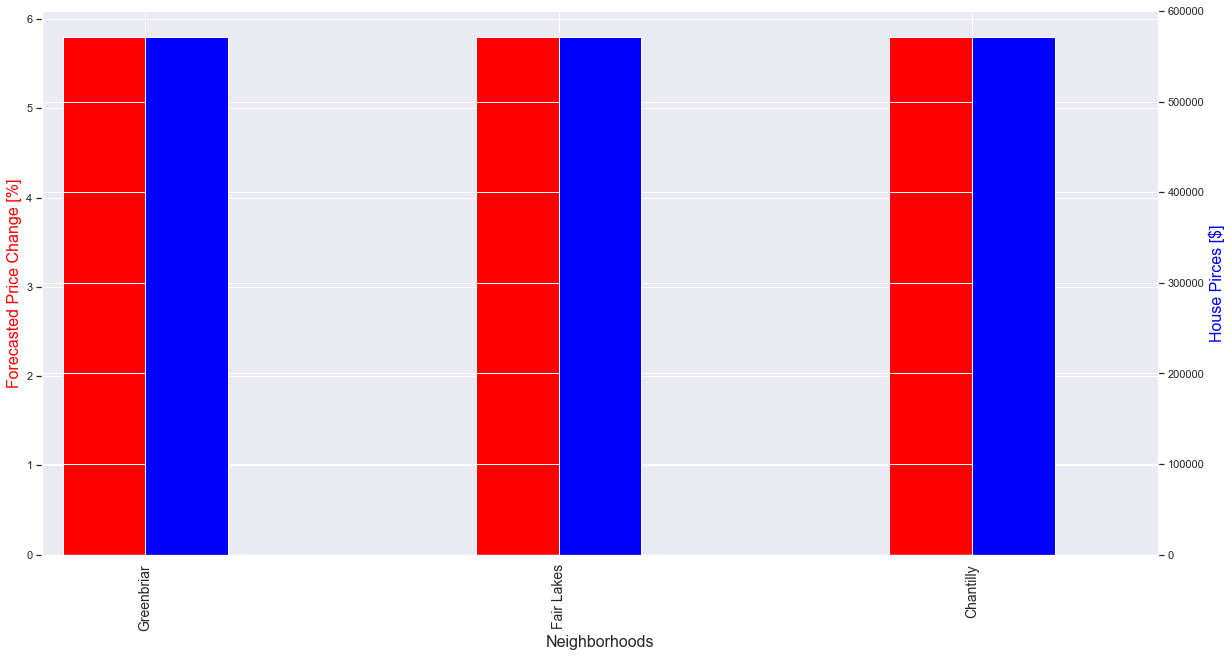

In [263]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax2 = ax.twinx()

width = 0.2
cluster2_house_price.ForecastYoYPctChange.plot(kind='bar', color='red', ax=ax, width=width, position=1)
cluster2_house_price.House_Price.astype(float).plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Forecasted Price Change [%]', color="red",fontsize=16)

ax2.set_ylabel('House Pirces [$]', color="blue",fontsize=16)
ax.set_xlabel('Neighborhoods', fontsize=16)
ax.set_xticklabels(cluster2_house_price.Neighborhoods, fontsize=14)
plt.show()

#### Cluster 3 - House Price

In [264]:
cluster3_house_price  = fairfax_merged_house_price_df.loc[fairfax_merged_house_price_df['Cluster Labels'] == 2, fairfax_merged_house_price_df.columns[[0] + list(range(5, fairfax_merged_house_price_df.shape[1]))]]
cluster3_house_price.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster3_house_price

Neighborhoods StateName CityName      CountyName ForecastedDate  \
3          McNair        VA  Herndon  Fairfax County     2022-02-28   
7          Floris        VA  Herndon  Fairfax County     2022-02-28   
13  Franklin Farm        VA  Herndon  Fairfax County     2022-02-28   

    ForecastYoYPctChange House_Price  Cluster Labels  
3                    5.7    688402.0               2  
7                    5.7    688402.0               2  
13                   5.7    688402.0               2

#### Create a bar plot of forecasted percentage price change and housing prices

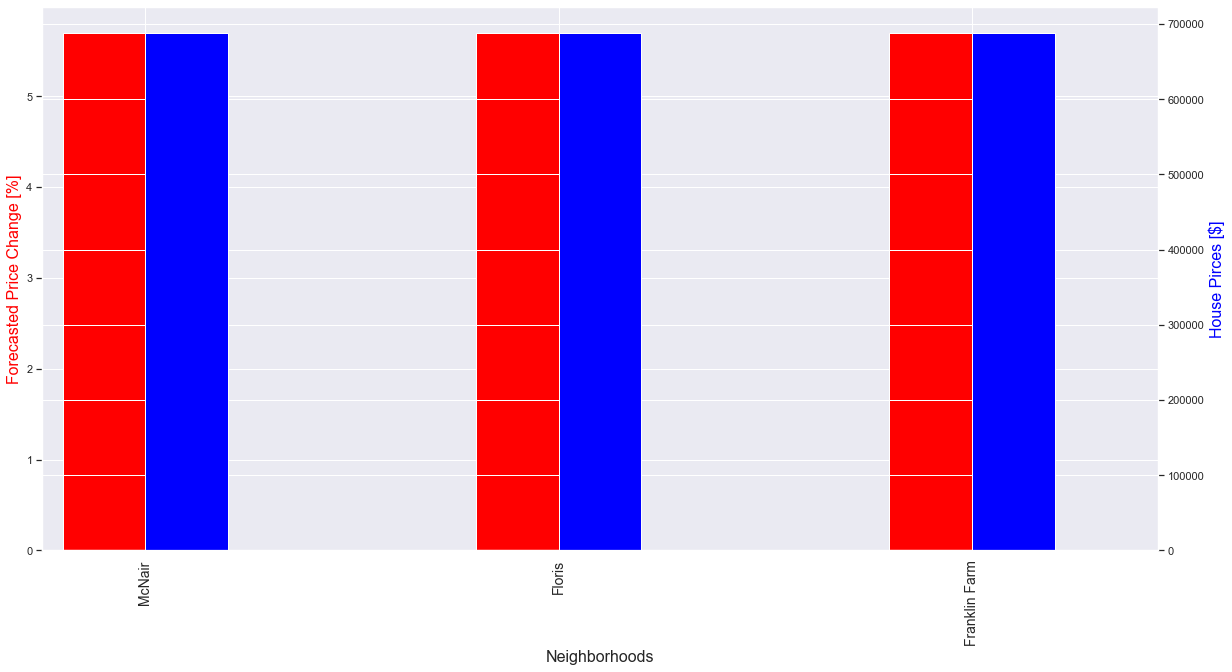

In [265]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax2 = ax.twinx()

width = 0.2
cluster3_house_price.ForecastYoYPctChange.plot(kind='bar', color='red', ax=ax, width=width, position=1)
cluster3_house_price.House_Price.astype(float).plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Forecasted Price Change [%]', color="red",fontsize=16)

ax2.set_ylabel('House Pirces [$]', color="blue",fontsize=16)
ax.set_xlabel('Neighborhoods', fontsize=16)
ax.set_xticklabels(cluster3_house_price.Neighborhoods, fontsize=14)
plt.show()

#### Cluster 4 - House Price

In [266]:
cluster4_house_price = fairfax_merged_house_price_df.loc[fairfax_merged_house_price_df['Cluster Labels'] == 3, fairfax_merged_house_price_df.columns[[0] + list(range(5, fairfax_merged_house_price_df.shape[1]))]]
cluster4_house_price.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster4_house_price

Neighborhoods StateName      CityName      CountyName ForecastedDate  \
36      Groveton        VA  Hybla Valley  Fairfax County     2022-02-28   
38  Hybla Valley        VA  Hybla Valley  Fairfax County     2022-02-28   

    ForecastYoYPctChange House_Price  Cluster Labels  
36                   5.8    543755.0               3  
38                   5.8    543755.0               3

#### Cluster 5 - House Price

In [267]:
cluster5_house_price = fairfax_merged_house_price_df.loc[fairfax_merged_house_price_df['Cluster Labels'] == 4, fairfax_merged_house_price_df.columns[[0] + list(range(5, fairfax_merged_house_price_df.shape[1]))]]
cluster5_house_price.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster5_house_price

Neighborhoods StateName     CityName      CountyName ForecastedDate  \
8          Kings Park        VA  Springfield  Fairfax County     2022-02-28   
11        Ravensworth        VA  Springfield  Fairfax County     2022-02-28   
44  North Springfield        VA  Springfield  Fairfax County     2022-02-28   

    ForecastYoYPctChange House_Price  Cluster Labels  
8                    6.0    593580.0               4  
11                   6.0    593580.0               4  
44                   6.0    593580.0               4

#### Run k-means to cluster the neighborhood into 5 cluster based on forecasted percentage price change in the housing prices 

##### Let's use the same dataframe that we created before for running k-mean clustering algorithm based housing prices and forecasted percentage change in the price of homes

In [268]:
cluster_forecast_change_df = fairfax_merged[['Neighborhoods', 'Latitude', 'Longitude','House_Price','ForecastYoYPctChange']].copy()
cluster_forecast_change_df.head()

Neighborhoods   Latitude  Longitude House_Price  ForecastYoYPctChange
0  Burke Centre  38.790992 -77.300519    595250.0                   5.8
1   Crosspointe  38.724002 -77.265078    555413.0                   5.8
2     Wakefield  38.835395 -77.239581    637630.0                   5.9
3        McNair  38.952295 -77.414295    688402.0                   5.7
4     South Run  38.747437 -77.281867    890128.0                   5.8

##### Perform one-hot encoding based forecasted percentage change in the price of houses

In [269]:
fairfax_onehot_forecast_change = pd.get_dummies(cluster_forecast_change_df[['ForecastYoYPctChange']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
fairfax_onehot_forecast_change['Neighborhoods'] = cluster_forecast_change_df['Neighborhoods'] 

# move neighborhood column to the first column
fixed_columns_test = [fairfax_onehot_forecast_change.columns[-1]] + list(fairfax_onehot_forecast_change.columns[:-1])
fairfax_onehot_forecast_change = fairfax_onehot_forecast_change[fixed_columns_test]

fairfax_onehot_forecast_change.head()

Neighborhoods  ForecastYoYPctChange
0  Burke Centre                   5.8
1   Crosspointe                   5.8
2     Wakefield                   5.9
3        McNair                   5.7
4     South Run                   5.8

In [270]:
# set number of clusters
kclusters = 5

fairfax_grouped_clustering_forecast_change = fairfax_onehot_forecast_change.drop('Neighborhoods', 1)
#fairfax_grouped_clustering_test = fairfax_onehot_test.drop('Neighborhoods', 1)
# run k-means clustering
kmeans_test = KMeans(n_clusters = kclusters, random_state = 0).fit(fairfax_grouped_clustering_forecast_change)

# check cluster labels generated for each row in the dataframe
kmeans_test.labels_[0:30] 

array([3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 2, 0, 3, 1, 3, 3, 3, 0, 3, 0, 4, 1,
       1, 1, 3, 1, 3, 4, 0, 0])

##### Create a 'Cluster Labels' column and add cluster labels to the dataframe

In [271]:
cluster_forecast_change_df['Cluster Labels'] = kmeans_test.labels_
cluster_forecast_change_df.head()

Neighborhoods   Latitude  Longitude House_Price  ForecastYoYPctChange  \
0  Burke Centre  38.790992 -77.300519    595250.0                   5.8   
1   Crosspointe  38.724002 -77.265078    555413.0                   5.8   
2     Wakefield  38.835395 -77.239581    637630.0                   5.9   
3        McNair  38.952295 -77.414295    688402.0                   5.7   
4     South Run  38.747437 -77.281867    890128.0                   5.8   

   Cluster Labels  
0               3  
1               3  
2               3  
3               1  
4               3

##### For convenience, make a copy of neighborhoods and cluster labels

In [272]:
new_cluster_forecast_change_df = cluster_forecast_change_df[['Neighborhoods', 'Cluster Labels']].copy()
new_cluster_forecast_change_df.head()

Neighborhoods  Cluster Labels
0  Burke Centre               3
1   Crosspointe               3
2     Wakefield               3
3        McNair               1
4     South Run               3

##### Create a new dataframe and add cluster labels

In [273]:
fairfax_merged_forecast_change_df = new_price_geo_data_fairfax 
fairfax_merged_forecast_change_df = fairfax_merged_forecast_change_df.join(new_cluster_forecast_change_df.set_index('Neighborhoods'), on='Neighborhoods')

fairfax_merged_forecast_change_df.head() # check the first columns!

Neighborhoods                                       Full_Address   Latitude  \
0  Burke Centre  Burke Centre, Fairfax County, Virginia, 22015-...  38.790992   
1   Crosspointe  Crosspointe, Laurel Hill, Fairfax County, Virg...  38.724002   
2     Wakefield  Wakefield Forest, Fairfax County, Virginia, 22...  38.835395   
3        McNair  McNair, Fairfax County, Virginia, 20171-3025, ...  38.952295   
4     South Run  South Run, Fairfax County, Virginia, 22039, Un...  38.747437   

   Longitude Zipcode StateName   CityName      CountyName ForecastedDate  \
0 -77.300519   22015        VA      Burke  Fairfax County     2022-02-28   
1 -77.265078   22079        VA     Lorton  Fairfax County     2022-02-28   
2 -77.239581   22003        VA  Annandale  Fairfax County     2022-02-28   
3 -77.414295   20171        VA    Herndon  Fairfax County     2022-02-28   
4 -77.281867   22039        VA     Lorton  Fairfax County     2022-02-28   

   ForecastYoYPctChange House_Price  Cluster Labels  
0                   5.8    595250.0               3  
1                   5.8    555413.0               3  
2                   5.9    637630.0               3  
3                   5.7    688402.0               1  
4                   5.8    890128.0               3

##### Let's visualize the resulting clusters based on forecasted percentage change in the price of homes

In [274]:
fairfax_county_latitude = 38.9085
fairfax_county_longitude = -77.2405
# create map
fairfax_map_clusters_forecast_change = folium.Map(location=[fairfax_county_latitude, fairfax_county_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add the borders onto the the map_fairfax
folium.GeoJson(
    fairfax_geo_json_data,
    style_function=lambda feature: {
        "fillColor": "#a89732",
        "color": "black",
        "weight": 2,
        "dashArray": "5, 5",
    },
).add_to(fairfax_map_clusters_forecast_change)


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(fairfax_merged_forecast_change_df['Latitude'], fairfax_merged_forecast_change_df['Longitude'], fairfax_merged_forecast_change_df['Neighborhoods'], fairfax_merged_forecast_change_df['Cluster Labels']):

    label = folium.Popup(str(poi) + ' Cluster '+ str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(fairfax_map_clusters_forecast_change)
       
fairfax_map_clusters_forecast_change

#### Analyze each cluster based on forecasted percentage change in the price of homes

#### Cluster 1 - Forecasted Change in Price

In [275]:
cluster1_forecast_change = fairfax_merged_forecast_change_df.loc[fairfax_merged_forecast_change_df['Cluster Labels'] == 0, fairfax_merged_forecast_change_df.columns[[0] + list(range(5, fairfax_merged_forecast_change_df.shape[1]))]]
cluster1_forecast_change.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster1_forecast_change

Neighborhoods StateName      CityName      CountyName  \
8            Kings Park        VA   Springfield  Fairfax County   
11          Ravensworth        VA   Springfield  Fairfax County   
42            Lincolnia        VA     Lincolnia  Fairfax County   
44    North Springfield        VA   Springfield  Fairfax County   
17             Woodlawn        VA  Mount Vernon  Fairfax County   
19        Seven Corners        VA  Falls Church  Fairfax County   
28  Bailey's Crossroads        VA  Falls Church  Fairfax County   
29          Belle Haven        VA   Belle Haven  Fairfax County   
41        Lake Barcroft        VA  Falls Church  Fairfax County   

   ForecastedDate  ForecastYoYPctChange House_Price  Cluster Labels  
8      2022-02-28                   6.0    593580.0               0  
11     2022-02-28                   6.0    593580.0               0  
42     2022-02-28                   6.0    541869.0               0  
44     2022-02-28                   6.0    593580.0               0  
17     2022-02-28                   6.1    501693.0               0  
19     2022-02-28                   6.1    538331.0               0  
28     2022-02-28                   6.1    431954.0               0  
29     2022-02-28                   6.1    653496.0               0  
41     2022-02-28                   6.1    538331.0               0

#### Create a bar plot of forecasted percentage price change and housing prices

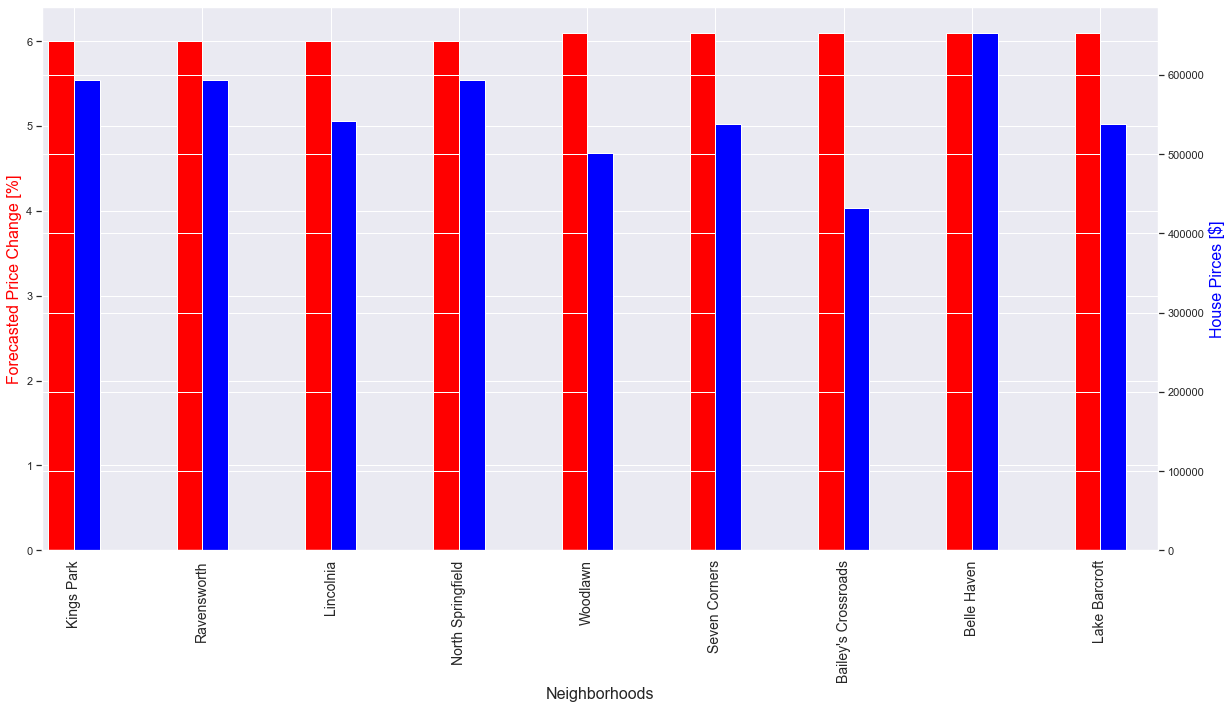

In [276]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax2 = ax.twinx()

width = 0.2
cluster1_forecast_change.ForecastYoYPctChange.plot(kind='bar', color='red', ax=ax, width=width, position=1)
cluster1_forecast_change.House_Price.astype(float).plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Forecasted Price Change [%]', color="red",fontsize=16)

ax2.set_ylabel('House Pirces [$]', color="blue",fontsize=16)
ax.set_xlabel('Neighborhoods', fontsize=16)
ax.set_xticklabels(cluster1_forecast_change.Neighborhoods, fontsize=14)
plt.show()

#### Cluster 2 - Forecasted Change in Price

In [277]:
cluster2_forecast_change = fairfax_merged_forecast_change_df.loc[fairfax_merged_forecast_change_df['Cluster Labels'] == 1, fairfax_merged_forecast_change_df.columns[[0] + list(range(5, fairfax_merged_forecast_change_df.shape[1]))]]
cluster2_forecast_change.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster2_forecast_change

Neighborhoods StateName      CityName      CountyName ForecastedDate  \
21         Mantua        VA       Fairfax  Fairfax County     2022-02-28   
22     Merrifield        VA       Fairfax  Fairfax County     2022-02-28   
25   Clifton town        VA       Clifton  Fairfax County     2022-02-28   
39       Idylwood        VA  Falls Church  Fairfax County     2022-02-28   
45   Pimmit Hills        VA  Falls Church  Fairfax County     2022-02-28   
3          McNair        VA       Herndon  Fairfax County     2022-02-28   
7          Floris        VA       Herndon  Fairfax County     2022-02-28   
13  Franklin Farm        VA       Herndon  Fairfax County     2022-02-28   
23  Tysons Corner        VA        McLean  Fairfax County     2022-02-28   
34      Fort Hunt        VA     Fort Hunt  Fairfax County     2022-02-28   

    ForecastYoYPctChange House_Price  Cluster Labels  
21                   5.6    653093.0               1  
22                   5.6    653093.0               1  
25                   5.6    771612.0               1  
39                   5.6    783622.0               1  
45                   5.6    783622.0               1  
3                    5.7    688402.0               1  
7                    5.7    688402.0               1  
13                   5.7    688402.0               1  
23                   5.7    779114.0               1  
34                   5.7    784641.0               1

#### Create a bar plot of forecasted percentage price change and housing prices

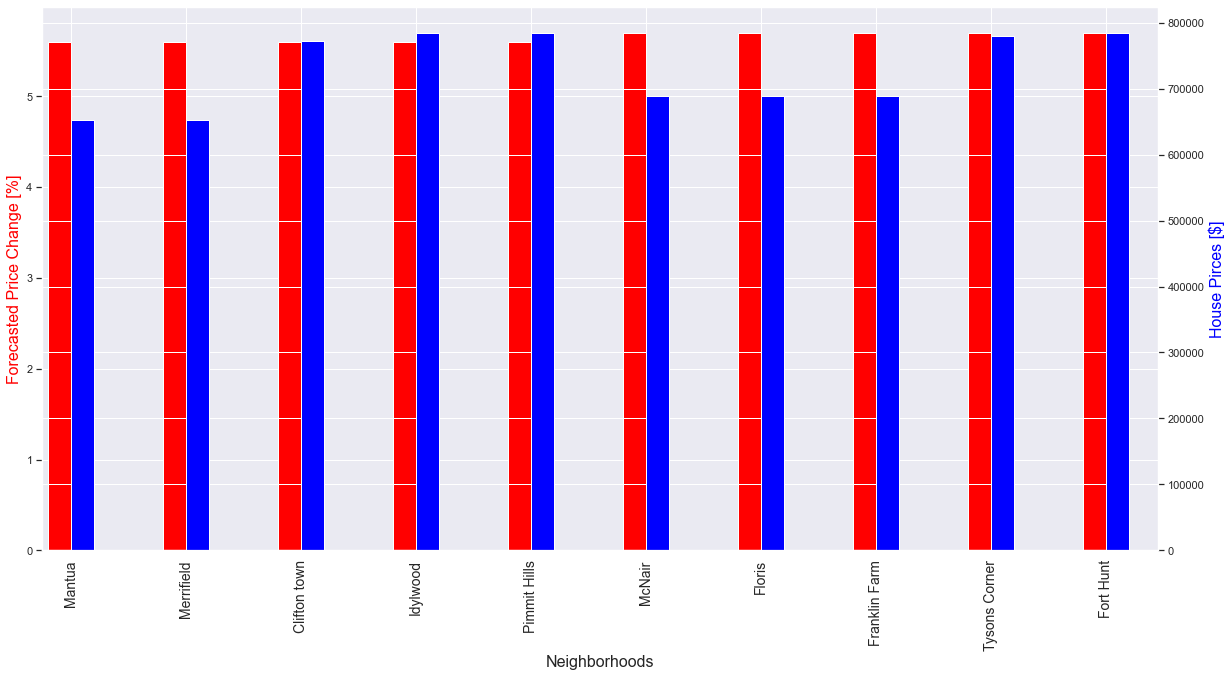

In [278]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax2 = ax.twinx()

width = 0.2
cluster2_forecast_change.ForecastYoYPctChange.plot(kind='bar', color='red', ax=ax, width=width, position=1)
cluster2_forecast_change.House_Price.astype(float).plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Forecasted Price Change [%]', color="red",fontsize=16)

ax2.set_ylabel('House Pirces [$]', color="blue",fontsize=16)
ax.set_xlabel('Neighborhoods', fontsize=16)
ax.set_xticklabels(cluster2_forecast_change.Neighborhoods, fontsize=14)
plt.show()

#### Cluster 3 - Forecasted Change in Price

In [279]:
cluster3_forecast_change  = fairfax_merged_forecast_change_df.loc[fairfax_merged_forecast_change_df['Cluster Labels'] == 2, fairfax_merged_forecast_change_df.columns[[0] + list(range(5, fairfax_merged_forecast_change_df.shape[1]))]]
cluster3_forecast_change.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster3_forecast_change

Neighborhoods StateName     CityName      CountyName ForecastedDate  \
33   Dunn Loring        VA  Dunn Loring  Fairfax County     2022-02-28   
10  George Mason        VA      Fairfax  Fairfax County     2022-02-28   

    ForecastYoYPctChange House_Price  Cluster Labels  
33                   5.1   1046272.0               2  
10                   5.2    634644.0               2

#### Create a bar plot of forecasted percentage price change and housing prices

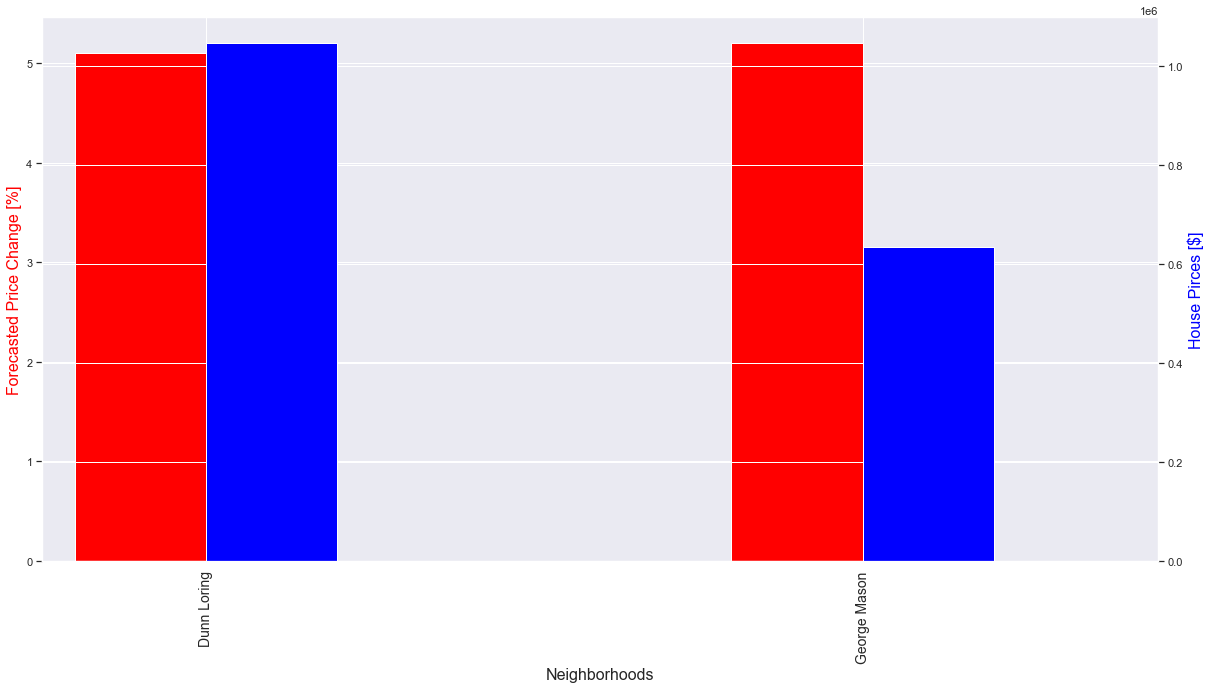

In [280]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax2 = ax.twinx()

width = 0.2
cluster3_forecast_change.ForecastYoYPctChange.plot(kind='bar', color='red', ax=ax, width=width, position=1)
cluster3_forecast_change.House_Price.astype(float).plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Forecasted Price Change [%]', color="red",fontsize=16)

ax2.set_ylabel('House Pirces [$]', color="blue",fontsize=16)
ax.set_xlabel('Neighborhoods', fontsize=16)
ax.set_xticklabels(cluster3_forecast_change.Neighborhoods, fontsize=14)
plt.show()

#### Cluster 4 - Forecasted Change in Price

In [281]:
cluster4_forecast_change = fairfax_merged_forecast_change_df.loc[fairfax_merged_forecast_change_df['Cluster Labels'] == 3, fairfax_merged_forecast_change_df.columns[[0] + list(range(5, fairfax_merged_forecast_change_df.shape[1]))]]
cluster4_forecast_change.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster4_forecast_change

Neighborhoods StateName      CityName      CountyName ForecastedDate  \
0        Burke Centre        VA         Burke  Fairfax County     2022-02-28   
35        Great Falls        VA   Great Falls  Fairfax County     2022-02-28   
32          Chantilly        VA       Fairfax  Fairfax County     2022-02-28   
30              Burke        VA         Burke  Fairfax County     2022-02-28   
26       Herndon town        VA       Herndon  Fairfax County     2022-02-28   
50        Springfield        VA   Springfield  Fairfax County     2022-02-28   
18        Laurel Hill        VA        Lorton  Fairfax County     2022-02-28   
16        Dranesville        VA       Herndon  Fairfax County     2022-02-28   
36           Groveton        VA  Hybla Valley  Fairfax County     2022-02-28   
38       Hybla Valley        VA  Hybla Valley  Fairfax County     2022-02-28   
46   West Springfield        VA   Springfield  Fairfax County     2022-02-28   
6          Fair Lakes        VA       Fairfax  Fairfax County     2022-02-28   
5          Greenbriar        VA       Fairfax  Fairfax County     2022-02-28   
4           South Run        VA        Lorton  Fairfax County     2022-02-28   
49             Reston        VA        Reston  Fairfax County     2022-02-28   
1         Crosspointe        VA        Lorton  Fairfax County     2022-02-28   
37         Huntington        VA    Huntington  Fairfax County     2022-02-28   
43          Newington        VA   Springfield  Fairfax County     2022-02-28   
40  West Falls Church        VA  Falls Church  Fairfax County     2022-02-28   
24          Annandale        VA     Annandale  Fairfax County     2022-02-28   
14         Kingstowne        VA     Rose Hill  Fairfax County     2022-02-28   
12        Long Branch        VA       Fairfax  Fairfax County     2022-02-28   
9     Kings Park West        VA       Fairfax  Fairfax County     2022-02-28   
2           Wakefield        VA     Annandale  Fairfax County     2022-02-28   
15   Newington Forest        VA   Springfield  Fairfax County     2022-02-28   
51          Rose Hill        VA     Rose Hill  Fairfax County     2022-02-28   

    ForecastYoYPctChange House_Price  Cluster Labels  
0                    5.8    595250.0               3  
35                   5.8   1234994.0               3  
32                   5.8    571477.0               3  
30                   5.8    595250.0               3  
26                   5.8    557876.0               3  
50                   5.8    549804.0               3  
18                   5.8    555413.0               3  
16                   5.8    557876.0               3  
36                   5.8    543755.0               3  
38                   5.8    543755.0               3  
46                   5.8    574793.0               3  
6                    5.8    571477.0               3  
5                    5.8    571477.0               3  
4                    5.8    890128.0               3  
49                   5.8    479682.0               3  
1                    5.8    555413.0               3  
37                   5.8    481086.0               3  
43                   5.9    608921.0               3  
40                   5.9    618723.0               3  
24                   5.9    637630.0               3  
14                   5.9    555972.0               3  
12                   5.9    680395.0               3  
9                    5.9    680395.0               3  
2                    5.9    637630.0               3  
15                   5.9    608921.0               3  
51                   5.9    555972.0               3

#### Create a bar plot of forecasted percentage price change and housing prices

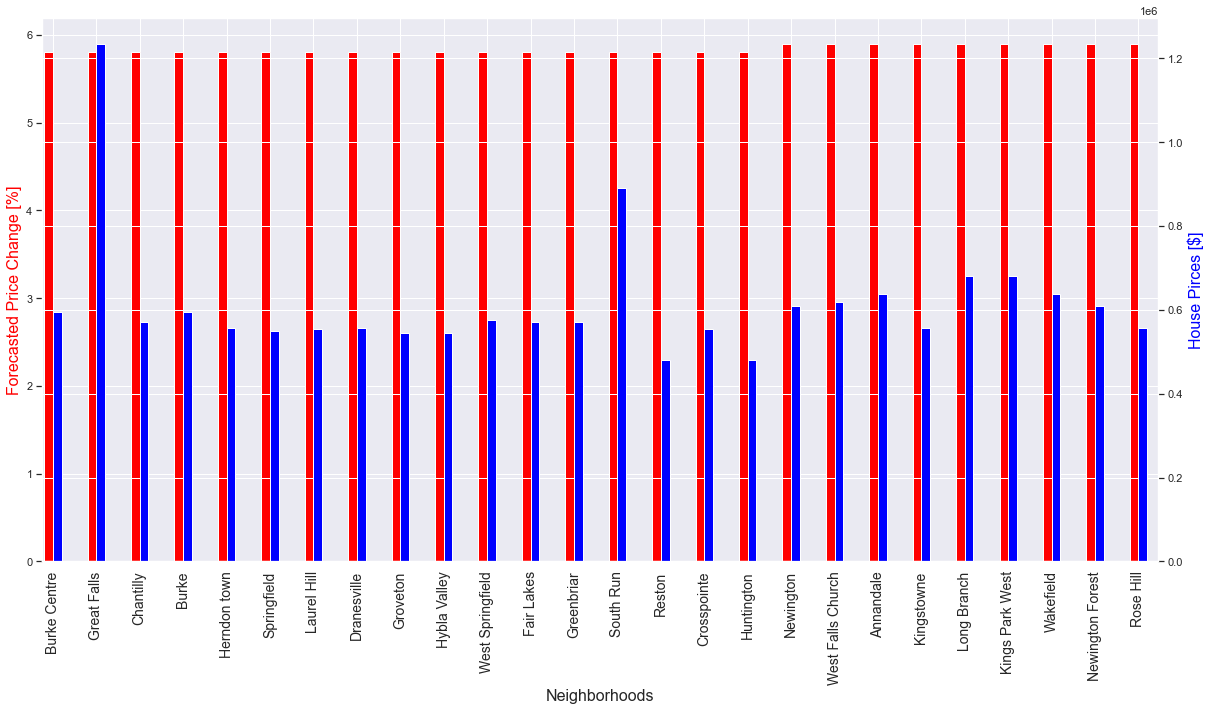

In [282]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax2 = ax.twinx()

width = 0.2
cluster4_forecast_change.ForecastYoYPctChange.plot(kind='bar', color='red', ax=ax, width=width, position=1)
cluster4_forecast_change.House_Price.astype(float).plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Forecasted Price Change [%]', color="red",fontsize=16)

ax2.set_ylabel('House Pirces [$]', color="blue",fontsize=16)
ax.set_xlabel('Neighborhoods', fontsize=16)
ax.set_xticklabels(cluster4_forecast_change.Neighborhoods, fontsize=14)
plt.show()

#### Cluster 5 - Forecasted Change in Price

In [283]:
cluster5_forecast_change = fairfax_merged_forecast_change_df.loc[fairfax_merged_forecast_change_df['Cluster Labels'] == 4, fairfax_merged_forecast_change_df.columns[[0] + list(range(5, fairfax_merged_forecast_change_df.shape[1]))]]
cluster5_forecast_change.sort_values(by =['ForecastYoYPctChange'], inplace=True, ascending=True)
cluster5_forecast_change

Neighborhoods StateName      CityName      CountyName ForecastedDate  \
20        McLean        VA        McLean  Fairfax County     2022-02-28   
27   Vienna town        VA        Vienna  Fairfax County     2022-02-28   
31  Fort Belvoir        VA  Fort Belvoir  Fairfax County     2022-02-28   
47     Wolf Trap        VA        Vienna  Fairfax County     2022-02-28   
48        Oakton        VA        Vienna  Fairfax County     2022-02-28   

    ForecastYoYPctChange House_Price  Cluster Labels  
20                   5.3   1255540.0               4  
27                   5.4    824915.0               4  
31                   5.4    644641.0               4  
47                   5.4    949536.0               4  
48                   5.5    858957.0               4

#### Create a bar plot of forecasted percentage price change and housing prices

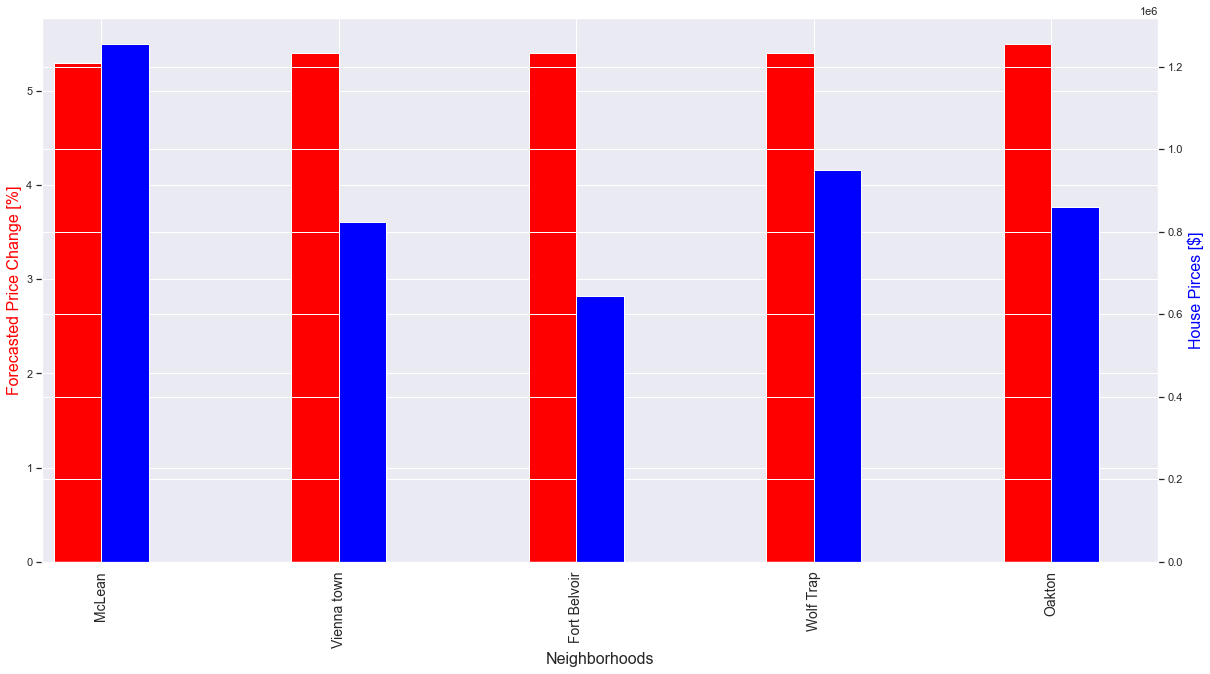

In [284]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax2 = ax.twinx()

width = 0.2
cluster5_forecast_change.ForecastYoYPctChange.plot(kind='bar', color='red', ax=ax, width=width, position=1)
cluster5_forecast_change.House_Price.astype(float).plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Forecasted Price Change [%]', color="red",fontsize=16)

ax2.set_ylabel('House Pirces [$]', color="blue",fontsize=16)
ax.set_xlabel('Neighborhoods', fontsize=16)
ax.set_xticklabels(cluster5_forecast_change.Neighborhoods, fontsize=14)
plt.show()

# The END